## AirBnB ML Data Analysis
### Final Project Submission

* Greyson Ford
* Raq Haque
* Geuntae Jang
* Samantha Kaplan
* Greg Lang
* Mohammad Rao

# Table of contents

In [1]:
# 1. Introduction and project aims

# 2. The dataset

# 3. Cleaning and pre-processing

# 4. Exploratory data analysis

# 5. Preparing the data for modeling

# 6. Machine Learning to predict Price

# 7. Conclusions and recommendations

***

# Introduction and project aims

We built on different group projects completed over the course of this class and wanted to investigate Airbnb pricing and location. Our aims were to find out if we could predict price based on a host of factors including amenities, location and other features.

Our aims included:
* How do we analyze the AirBnB dataset? 

* What are the most popular areas for NYC Airbnbs?

* What are the most popular listing types?

* How long have hosts been listing properties on Airbnb?

* What is the distribution of guests accommodated in listings and how does this affect prices? 

* What is the distribution of reviews? 






***

# The dataset

The dataset used for this project comes from [Inside AirBnb](http://insideairbnb.com/get-the-data.html), an anti-Airbnb lobby group that scrapes Airbnb listings, reviews and calendar data for multiple cities around the world. The dataset was scraped on August 6, 2019 and contains information on all NYC Airbnb listings that were live on the site on that date. A GeoJSON file of NYC boundaries was also downloaded from the same site.

The data is quite messy, and has some limitations. The major one is that it only includes the advertised price (sometimes called the 'sticker' price). The sticker price is the overall nightly price that is advertised to potential guests, rather than the actual average amount paid per night by previous guests. The advertised prices can be set to any arbitrary amount by the host, and hosts that are less experienced with Airbnb will often set these to very low (e.g. 0 USD) or very high (e.g. 10,000 USD) amounts.

Nevertheless, this dataset can be used as a proof of concept. A more accurate version could be built using data on the actual average nightly rates paid, e.g. from sites like [AirDNA](https://www.airdna.co/) that sell higher quality Airbnb data.

***

# Cleaning and pre-processing

### Importing the libraries and data

In [2]:
import warnings
warnings.filterwarnings('ignore')
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from tensorflow.keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

Using TensorFlow backend.


In [3]:
import gzip
import csv
import json
import pandas as pd
data = pd.read_csv('listings.csv.gz', compression='gzip',
                   error_bad_lines=False)
data.describe()

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,4.886400e+04,4.886400e+04,0.0,0.0,0.0,4.886400e+04,0.0,48846.000000,48846.000000,48864.000000,...,37738.000000,37706.000000,37728.000000,37701.000000,37703.000000,48864.000000,48864.000000,48864.000000,48864.000000,38733.000000
mean,1.940851e+07,2.019081e+13,NaN,NaN,NaN,6.943161e+07,NaN,14.832269,14.832269,40.728664,...,9.278181,9.748820,9.755831,9.567492,9.398748,7.438278,5.788044,1.538740,0.111493,1.365694
std,1.124290e+07,1.306263e+01,NaN,NaN,NaN,8.058217e+07,NaN,88.245394,88.245394,0.054794,...,1.084325,0.719149,0.731741,0.762230,0.912826,34.949053,34.006697,6.439867,0.993281,1.692891
min,2.595000e+03,2.019081e+13,NaN,NaN,NaN,2.438000e+03,NaN,0.000000,0.000000,40.499790,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,9.577635e+06,2.019081e+13,NaN,NaN,NaN,8.048590e+06,NaN,1.000000,1.000000,40.689797,...,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.190000
50%,1.994839e+07,2.019081e+13,NaN,NaN,NaN,3.168654e+07,NaN,1.000000,1.000000,40.722880,...,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,0.000000,0.710000
75%,2.974014e+07,2.019081e+13,NaN,NaN,NaN,1.096553e+08,NaN,2.000000,2.000000,40.762970,...,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,1.000000,1.000000,0.000000,2.000000
max,3.749909e+07,2.019081e+13,NaN,NaN,NaN,2.830244e+08,NaN,1465.000000,1465.000000,40.912400,...,10.000000,10.000000,10.000000,10.000000,10.000000,343.000000,335.000000,115.000000,23.000000,66.610000


### Dropping initial columns

NLP will not be used in the creation of an initial model (although they could be used to augment the model later, e.g. through sentiment analysis). Therefore, free text columns will be dropped for now, as will other columns which are not useful for predicting price (e.g. url, host name and other host-related features that are unrelated to the property).

In [4]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space',
                'description', 'neighborhood_overview']
data = data.drop(cols_to_drop, axis=1)
print("Dropped plain text columns.")
data.head()

Dropped plain text columns.


,id,experiences_offered,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,none,NaN,Apartment is located on 37th Street between 5t...,"Guests have full access to the kitchen, bathro...",I am a Sound Therapy Practitioner and Kundalin...,"Make yourself at home, respect the space and t...",NaN,NaN,https://a0.muscache.com/im/pictures/f0813a11-4...,...,f,f,strict_14_with_grace_period,t,t,2,1,0,1,0.39
1,3647,none,NaN,NaN,NaN,NaN,Upon arrival please have a legibile copy of yo...,NaN,NaN,https://a0.muscache.com/im/pictures/838341/9b3...,...,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
2,3831,none,NaN,B52 bus for a 10-minute ride to downtown Brook...,You will have exclusive use of and access to: ...,"We'll be around, but since you have the top fl...",Smoking - outside please; pets allowed but ple...,NaN,NaN,https://a0.muscache.com/im/pictures/e49999c2-9...,...,f,f,moderate,f,f,1,1,0,0,4.64
3,5022,none,NaN,NaN,NaN,NaN,Please be considerate when staying in the apar...,NaN,NaN,https://a0.muscache.com/im/pictures/feb453bd-f...,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.10
4,5099,none,Read My Full Listing For All Information. New ...,From the apartment is a 10 minute walk to Gran...,I will meet you upon arrival.,I usually check in with guests via text or ema...,• Check-in time is 2PM. • Check-out time is 12...,NaN,NaN,https://a0.muscache.com/im/pictures/be2fdcf6-e...,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.60


In [5]:
cols_to_drop = ['notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url']
data = data.drop(cols_to_drop, axis=1)
print("Dropped plain text columns.")
data.head()

Dropped plain text columns.


,id,experiences_offered,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,none,NaN,2845,https://www.airbnb.com/users/show/2845,Jennifer,2008-09-09,"New York, New York, United States",A New Yorker since 2000! My passion is creatin...,within a few hours,...,f,f,strict_14_with_grace_period,t,t,2,1,0,1,0.39
1,3647,none,NaN,4632,https://www.airbnb.com/users/show/4632,Elisabeth,2008-11-25,"New York, New York, United States",Make Up Artist National/ (Website hidden by Ai...,within a day,...,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
2,3831,none,NaN,4869,https://www.airbnb.com/users/show/4869,LisaRoxanne,2008-12-07,"New York, New York, United States",Laid-back bi-coastal actor/professor/attorney.,within an hour,...,f,f,moderate,f,f,1,1,0,0,4.64
3,5022,none,NaN,7192,https://www.airbnb.com/users/show/7192,Laura,2009-01-29,"Miami, Florida, United States",I have been a NYer for almost 10 years. I came...,NaN,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.10
4,5099,none,NaN,7322,https://www.airbnb.com/users/show/7322,Chris,2009-02-02,"New York, New York, United States","I'm an artist, writer, traveler, and a native ...",within a few hours,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.60


In [6]:
cols_to_drop = ['xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about']
data = data.drop(cols_to_drop, axis=1)
print("Dropped plain text columns.")
data.head()

Dropped plain text columns.


,id,experiences_offered,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,none,2008-09-09,within a few hours,90%,NaN,f,https://a0.muscache.com/im/users/2845/profile_...,https://a0.muscache.com/im/users/2845/profile_...,Midtown,...,f,f,strict_14_with_grace_period,t,t,2,1,0,1,0.39
1,3647,none,2008-11-25,within a day,100%,NaN,f,https://a0.muscache.com/im/users/4632/profile_...,https://a0.muscache.com/im/users/4632/profile_...,Harlem,...,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
2,3831,none,2008-12-07,within an hour,90%,NaN,f,https://a0.muscache.com/im/users/4869/profile_...,https://a0.muscache.com/im/users/4869/profile_...,Clinton Hill,...,f,f,moderate,f,f,1,1,0,0,4.64
3,5022,none,2009-01-29,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/7192/profile_...,https://a0.muscache.com/im/users/7192/profile_...,East Harlem,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.10
4,5099,none,2009-02-02,within a few hours,90%,NaN,f,https://a0.muscache.com/im/pictures/user/26745...,https://a0.muscache.com/im/pictures/user/26745...,Flatiron District,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.60


In [7]:
cols_to_drop = ['host_thumbnail_url', 'host_picture_url', 'host_neighbourhood']
data = data.drop(cols_to_drop, axis=1)
print("Dropped plain text columns.")
data.head()

Dropped plain text columns.


,id,experiences_offered,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,none,2008-09-09,within a few hours,90%,NaN,f,5.0,5.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",...,f,f,strict_14_with_grace_period,t,t,2,1,0,1,0.39
1,3647,none,2008-11-25,within a day,100%,NaN,f,1.0,1.0,"['email', 'phone', 'google', 'reviews', 'jumio...",...,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
2,3831,none,2008-12-07,within an hour,90%,NaN,f,1.0,1.0,"['email', 'phone', 'reviews', 'kba']",...,f,f,moderate,f,f,1,1,0,0,4.64
3,5022,none,2009-01-29,NaN,NaN,NaN,f,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.10
4,5099,none,2009-02-02,within a few hours,90%,NaN,f,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.60


In [8]:
cols_to_drop = ['host_verifications', 'calendar_last_scraped']
df = data.drop(cols_to_drop, axis=1)
print("Dropped plain text columns.")
df.head()

Dropped plain text columns.


,id,experiences_offered,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,none,2008-09-09,within a few hours,90%,NaN,f,5.0,5.0,t,...,f,f,strict_14_with_grace_period,t,t,2,1,0,1,0.39
1,3647,none,2008-11-25,within a day,100%,NaN,f,1.0,1.0,t,...,f,f,strict_14_with_grace_period,t,t,1,0,1,0,NaN
2,3831,none,2008-12-07,within an hour,90%,NaN,f,1.0,1.0,t,...,f,f,moderate,f,f,1,1,0,0,4.64
3,5022,none,2009-01-29,NaN,NaN,NaN,f,1.0,1.0,t,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.10
4,5099,none,2009-02-02,within a few hours,90%,NaN,f,1.0,1.0,t,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.60


In [9]:
# List columns left in data set
print(list(df.columns.values))

['id', 'experiences_offered', 'host_since', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of

Other columns can be dropped because they contain a majority of null entries.

In [10]:
df.isna().sum()

id                                                  0
experiences_offered                                 0
host_since                                         18
host_response_time                              16582
host_response_rate                              16582
host_acceptance_rate                            48864
host_is_superhost                                  18
host_listings_count                                18
host_total_listings_count                          18
host_has_profile_pic                               18
host_identity_verified                             18
street                                              0
neighbourhood                                      11
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                        0
city                                               62
state                                               5
zipcode                                           515
market                      

In [11]:
df.drop(['host_acceptance_rate', 'square_feet', 'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'], axis=1, inplace=True)

df.set_index('id', inplace=True) # The id will be used as the index, as this could be useful in future e.g. if a separate dataset containing reviews for each property is linked to this one


### Dropping initial columns

In [12]:
# Verifying that we now have mostly non-null columns
df.isna().sum()

experiences_offered                                 0
host_since                                         18
host_response_time                              16582
host_response_rate                              16582
host_is_superhost                                  18
host_listings_count                                18
host_total_listings_count                          18
host_has_profile_pic                               18
host_identity_verified                             18
street                                              0
neighbourhood                                      11
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                        0
city                                               62
state                                               5
zipcode                                           515
market                                            103
smart_location                                      0
country_code                

host_listings_count and host_total_listings_count are the same in all but 18 cases. These cases are those where the value is NaN. Therefore one of these columns can be dropped. Other columns which split these into type of property will also be dropped, as they will be highly correlated (one will be the total of the others):

In [13]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]

18


,experiences_offered,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
1281257,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"New York, NY, United States",...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.28
1523556,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, NY, United States",...,f,f,moderate,f,f,1,0,1,0,0.06
4446862,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, NY, United States",...,f,f,flexible,f,f,1,0,1,0,NaN
4616452,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"New York, NY, United States",...,f,f,moderate,f,f,1,1,0,0,0.03
4763327,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Brooklyn, NY, United States",...,f,f,moderate,f,f,1,1,0,0,0.02


In [14]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)
print("Done")

Done


There are multiple columns for property location, including an attempt by the site that originally scraped the data to clean up the neighbourhood locations. Some of these columns can be dropped. Because all of the listings are in NYC, columns relating to city and country can be dropped. Two columns for neighborhood and borough will be kept - 'neighboorhood_cleansed', and 'neighbourhood_group_cleansed'. We're also saving zipcode for now.

Latitude and longitude will be saved in a dataframe for later use (see modelling section below).

In [15]:
lat_long = df[['latitude', 'longitude']]

In [16]:
df.drop(['latitude', 'longitude', 'street', 'neighbourhood', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

There are multiple columns for minimum and maximum night stays, but the two main ones will be used as there are few differences between e.g. minimum_nights and minimum_minimum_nights. The latter presumably refers to the fact that min/max night stays can vary over the year. The default (i.e. most frequently applied) min/max night stay values will be used instead.

In [17]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

2012

In [18]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)
print("done")

done


Checking whether boolean and categorical features contain sufficient numbers of instances in each category to make them worth including:

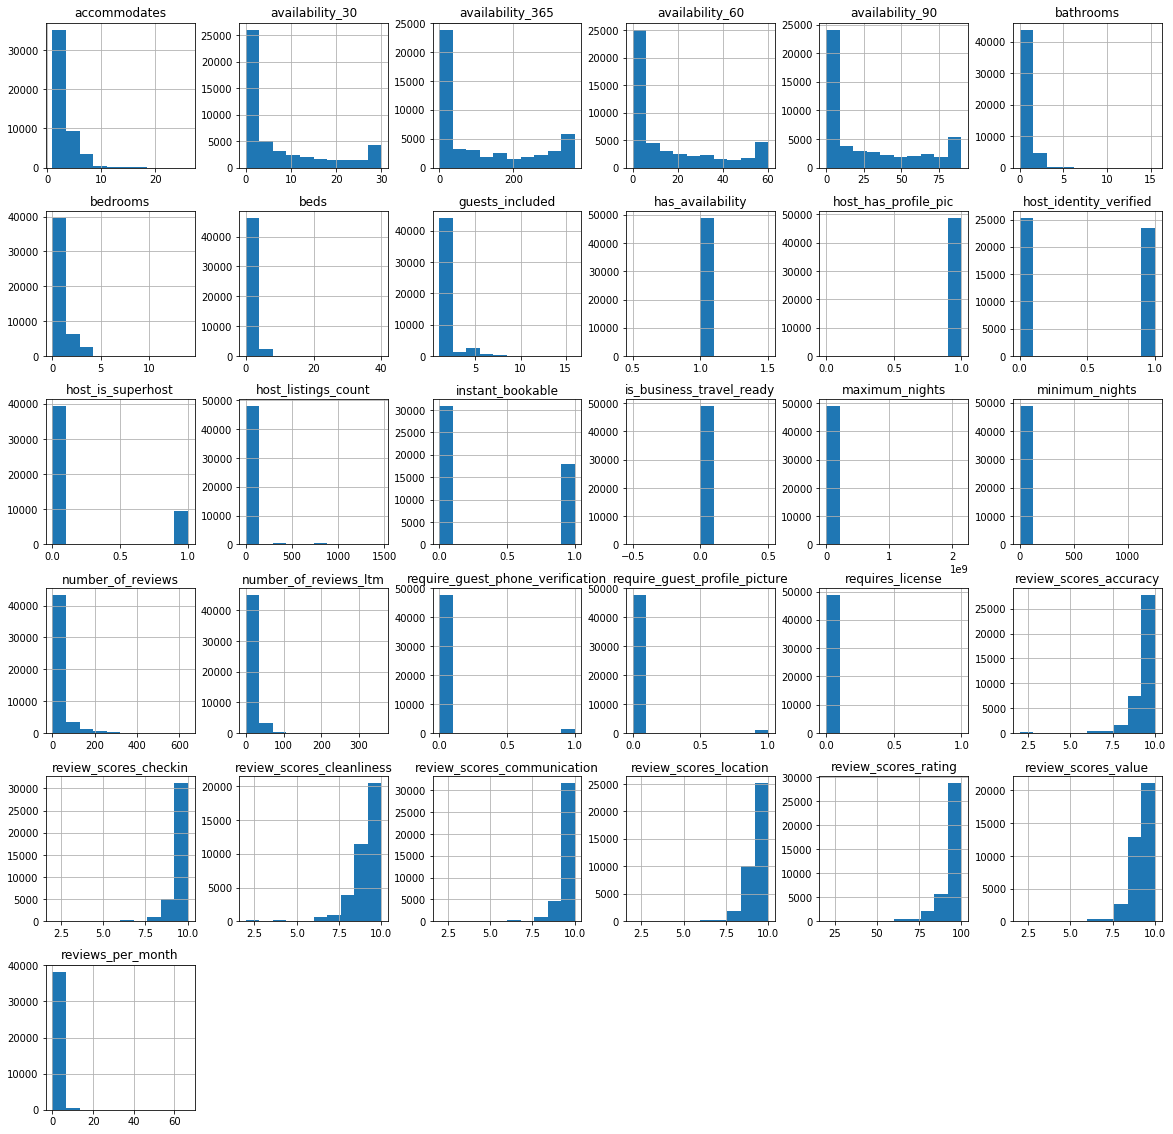

In [19]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

From the above, it can be seen that several columns only contain one category and can be dropped. Also, some columns provode useless info (like require_guest_profile_picture).

In [20]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)
print("Done")

Done


In [21]:
# List columns left in data set
print(list(df.columns.values))

['experiences_offered', 'host_since', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'host_identity_verified', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'cancellation_policy', 'reviews_per_month']


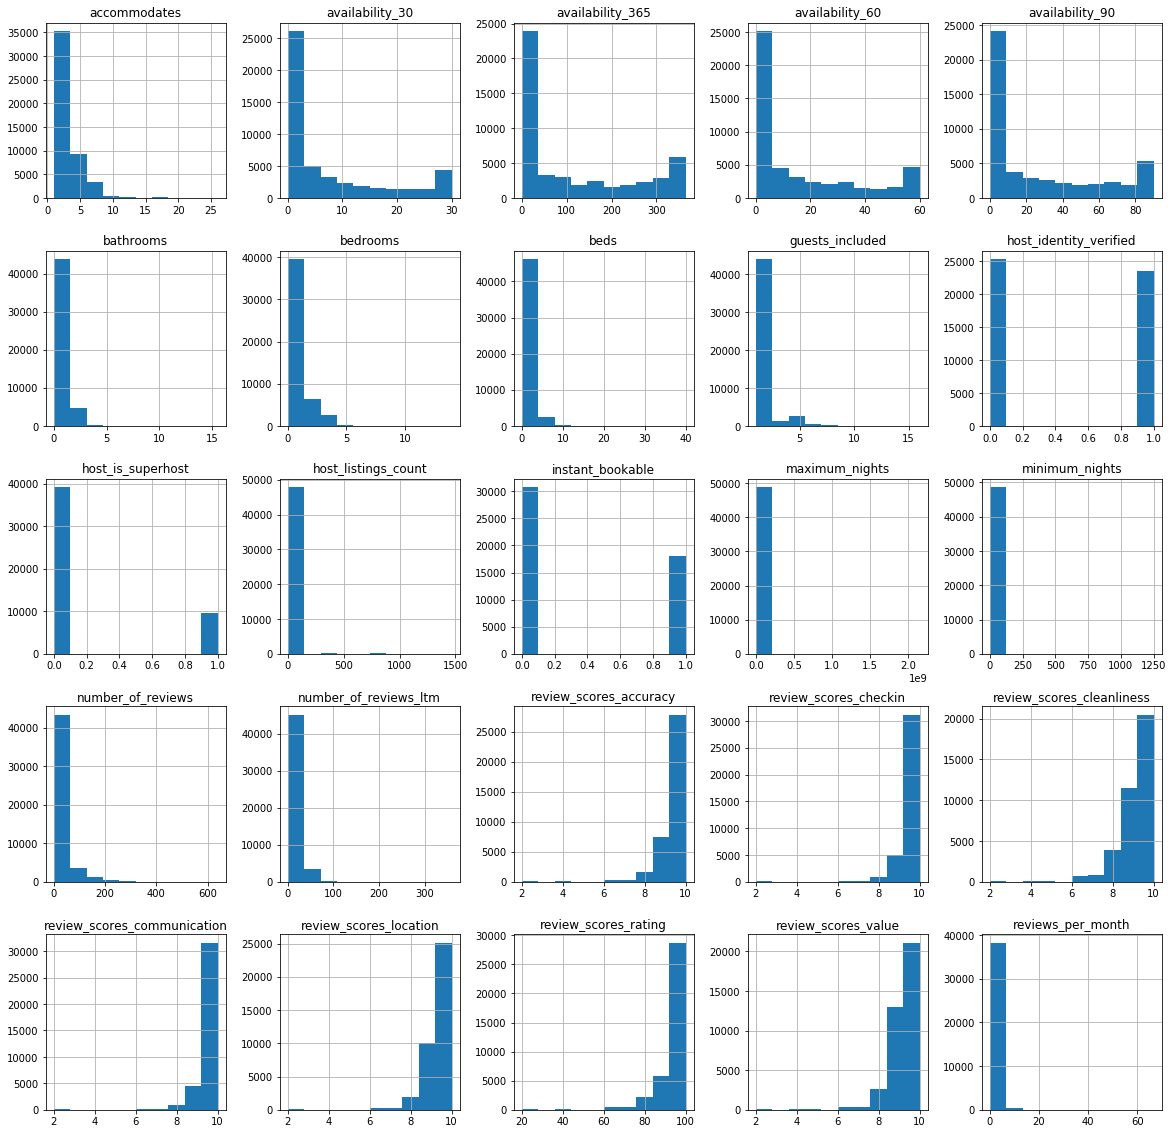

In [22]:
# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

In [23]:
# A couple more single-category columns
df.drop(['maximum_nights','minimum_nights'], axis=1, inplace=True)
print("Done")

Done


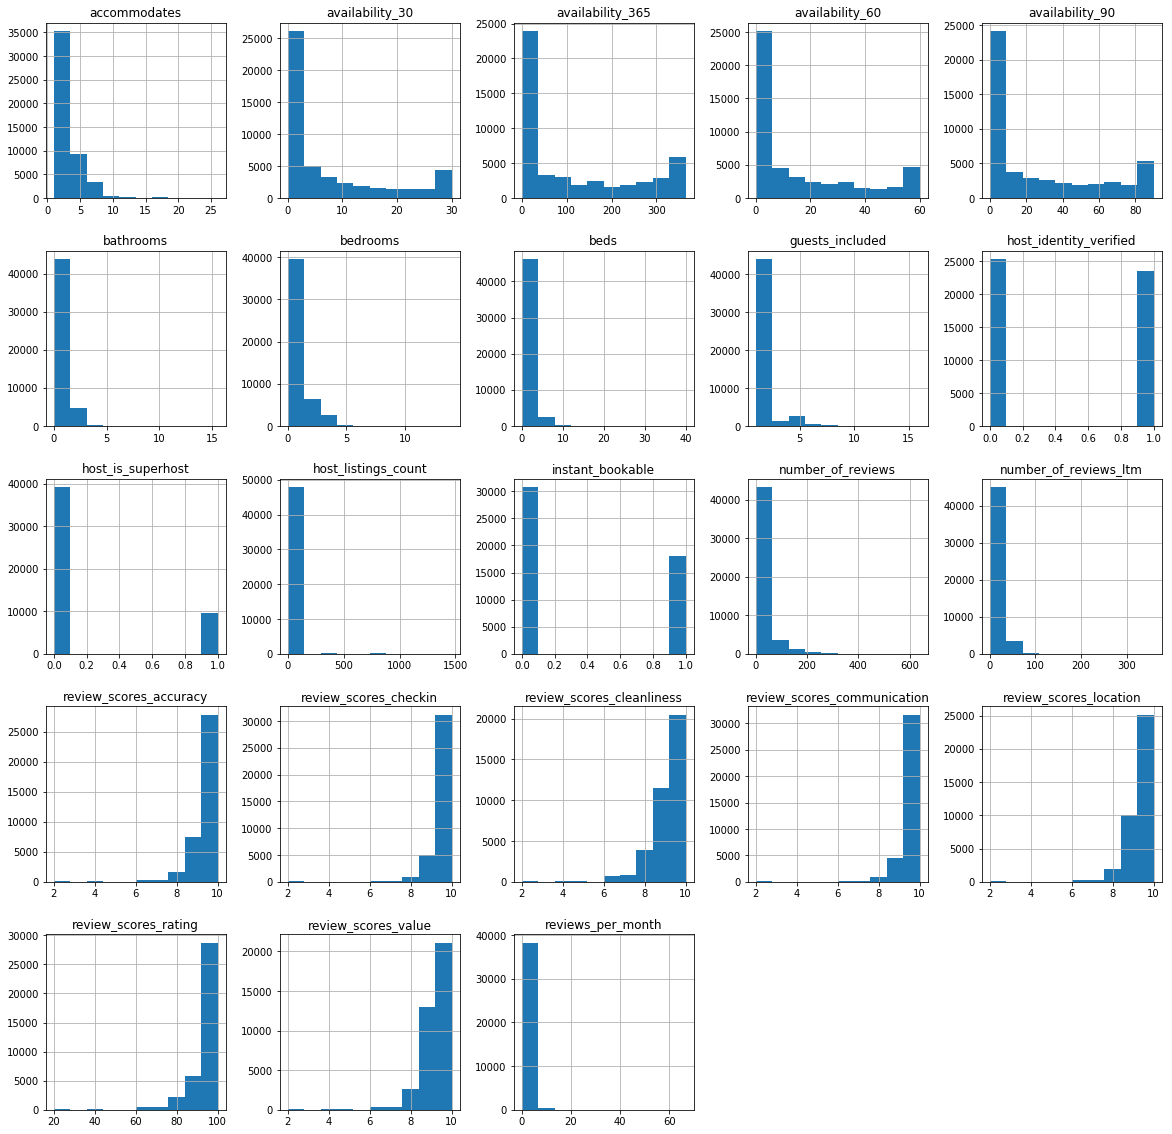

In [24]:
# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

### Description of each column:
- experiences_offered - slightly unclear as it does not appear to directly relate to Airbnb Experiences, but this seems to be the main recommended category of travel type, e.g. business
- host_since - date that the host first joined Airbnb
- host_response_time - average amount of time the host takes to reply to messages
- host_response_rate - proportion of messages that the host replies to
- host_is_superhost - whether or not the host is a superhost, which is a mark of quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb
- host_listings_count - how many listings the host has in total
- host_identity_verified - whether or not the host has been verified with id
- neighbourhood_cleansed - the neighborhood the property is in
- neighbourhood_group_cleansed - the borough
- zipcode - the zip code
- property_type - type of property, e.g. house or flat
- room_type - type of listing, e.g. entire home, private room or shared room
- accommodates - how many people the property accommodates
- bathrooms - number of bathrooms
- bedrooms - number of bedrooms
- beds - number of beds
- bed_type - type of bed, e.g. real bed or sofa-bed
- amenities - list of amenities
- price - nightly advertised price (the target variable)
- security_deposit - the amount required as a security deposit
- cleaning_fee - the amount of the cleaning fee (a fixed amount paid per booking)
- guests_included - the number of guests included in the booking fee
- extra_people - the price per additional guest above the guests_included price
- calendar_updated - when the host last updated the calendar
- availability_30 - how many nights are available to be booked in the next 30 days
- availability_60 - how many nights are available to be booked in the next 60 days
- availability_90 - how many nights are available to be booked in the next 90 days
- availability_365 - how many nights are available to be booked in the next 365 days
- number_of_reviews - the number of reviews left for the property
- number_of_reviews_ltm - the number of reviews left for the property in the last twelve months
- first_review - the date of the first review
- last_review - the date of the most recent review
- review_scores_rating - guests can score properties overall from 1 to 5 stars
- review_scores_accuracy - guests can score the accuracy of a property's description from 1 to 5 stars
- review_scores_cleanliness - guests can score a property's cleanliness from 1 to 5 stars
- review_scores_checkin - guests can score their check-in from 1 to 5 stars
- review_scores_communication - guests can score a host's communication from 1 to 5 stars
- review_scores_location - guests can score a property's location from 1 to 5 stars
- review_scores_value - guests can score a booking's value for money from 1 to 5 stars
- instant_bookable - whether or not the property can be instant booked (i.e. booked straight away, without having to message the host first and wait to be accepted)
- cancellation_policy - the type of cancellation policy, e.g. strict or moderate
- reviews_per_month - calculated field of the average number of reviews left by guest each month

### Cleaning individual columns

**experiences_offered**

Most listings offer no experiences so this feature can be dropped.

In [25]:
df.experiences_offered.value_counts()

none    48864
Name: experiences_offered, dtype: int64

In [26]:
df.drop('experiences_offered', axis=1, inplace=True)

**host_since**

This is a datetime column, and will be converted into a measure of the number of days that a host has been on the platform, measured from the date that the data was scraped (10 July, 2019). The original column will be left in initially for EDA, and dropped later.

In [27]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime(2019, 7, 10) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1534.0
Median days as host: 1533.0


**host_response_time**

About a third of rows don't have a value for host_response_time, and the majority of these have also not yet been reviewed. Therefore this section of the dataset consists primarily of properties which have not yet had a completed stay (most likely properties which have not yet had a booking, although may also include properties that have a booking currently occuring). Although this is a considerable proportion of the dataset, these listings will be retained in the data because they are still legitimate properties with advertised prices, and are still part of the comparative market when considering the price for which to advertise your Airbnb listing. However, if the dataset being used had the actual average price paid as its target, it would be necessary to drop these rows because they would not have a value, as they have not yet been booked.

It is worth noting, however, that this group of listings probably also contains a large number of 'inactive' listings. 

Because host_response_time is unknown for so many listings, it will be retained as its own category, 'unknown'.

In [28]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
len(df[df.loc[ :,['host_response_time ', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 16582
Proportion: 33.9%


10131

In [29]:
df.host_response_time.fillna("unknown", inplace=True)

In [30]:
df.host_response_time.value_counts(normalize=True)

within an hour        0.391699
unknown               0.339350
within a few hours    0.150049
within a day          0.099030
a few days or more    0.019871
Name: host_response_time, dtype: float64

**host_response_rate**

A similar story is true for host_response_rate, with about a third of values being null. This will also be kept as its own category, after grouping other values into meaningful groups (i.e. transforming this into a categorical feature, rather than a numerical one). Because about 67% of hosts respond 100% of the time, this will be kept as its own category, and other values will be grouped into bins.

In [31]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 16582
Proportion: 33.9%


In [32]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 93.0
Median host response rate: 100.0
Proportion of 100% host response rates: 67.7%


In [33]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       21848
unknown    16582
50-89%      5553
90-99%      3407
0-49%       1474
Name: host_response_rate, dtype: int64

**host_is_superhost**

There are 18 rows lacking values for each of five different host-related features. These rows will be dropped.

In [34]:
# Number of rows without a value for multiple host-related columns
len(df[df.loc[ :,['host_since ', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 'host_identity_verified'] ].isnull().sum(axis=1) == 5])

18

In [35]:
df.dropna(subset=['host_since'], inplace=True)

**property_type**

Some cleaning of property types is required as there are a large number of categories with only a few listings. The categories 'apartment', 'house' and 'other' will be used, as most properties can be classified as either apartments or houses.

In [36]:
df.property_type.value_counts()

Apartment                 38589
House                      3846
Townhouse                  1659
Condominium                1494
Loft                       1412
Serviced apartment          505
Guest suite                 363
Hotel                       227
Boutique hotel              190
Other                       118
Bed and breakfast            87
Resort                       72
Hostel                       62
Guesthouse                   56
Bungalow                     38
Villa                        28
Tiny house                   19
Aparthotel                   17
Boat                         13
Camper/RV                    10
Cottage                       7
Tent                          6
Earth house                   4
Cabin                         3
Houseboat                     3
Casa particular (Cuba)        2
Yurt                          2
Barn                          2
Farm stay                     2
Bus                           2
Cave                          2
Castle  

In [37]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Condominium': 'Apartment',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Hotel': 'Apartment',
    'Boutique hotel': 'Apartment',
    'Bed and breakfast': 'Apartment',
    'Hostel': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Cabin': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [38]:
df.property_type.value_counts()

Apartment    42566
House         5604
Other          676
Name: property_type, dtype: int64

**bathrooms, bedrooms and beds**

Missing values will be replaced with the median (to avoid strange fractions).

In [39]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

**bed_type**

Most listings have the same bed type so this feature can be dropped.

In [40]:
df.bed_type.value_counts()

Real Bed         48059
Futon              294
Pull-out Sofa      250
Airbed             171
Couch               72
Name: bed_type, dtype: int64

In [41]:
df.drop('bed_type', axis=1, inplace=True)

**Amenities**

Amenities is a list of additional features in the property, e.g. whether it has a TV or parking. Examples are below:

In [42]:
# Example of amenities listed
df.amenities[:1].values

array(['{TV,Wifi,"Air conditioning",Kitchen,"Paid parking off premises","Free street parking","Indoor fireplace",Heating,"Family/kid friendly","Smoke detector","Carbon monoxide detector","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in",Keypad,"Private living room",Bathtub,"Hot water","Bed linens","Extra pillows and blankets","Ethernet connection","Coffee maker",Refrigerator,"Dishes and silverware","Cooking basics",Oven,Stove,"Luggage dropoff allowed","Long term stays allowed","Cleaning before checkout","Wide entrance for guests","Flat path to guest entrance","Well-lit path to entrance","No stairs or steps to enter"}'],
      dtype=object)

In [43]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Breakfast',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling hoist',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Extra space around bed',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for shower',
 'Fixed grab bars for toilet',
 'Flat path to 

In the list above, some amenities are more important than others (e.g. Cable TV is more likely to increase price than a ceiling hoist), and some are likely to be fairly uncommon in NYC (e.g. 'BBQ Grill'). 

The amenities chosen are (slashes indicate separate categories that can be combined):
- 24-hour check-in
- Air conditioning
- Bathtub/ Bathtub with bath chair
- Beachfront
- Bed linens
- Breakfast
- Building staff/ Doorman
- Buzzer/wireless intercom
- Cable TV/ TV
- Carbon monoxide detector
- Cat(s)/ Dog(s)/ Other pet(s)/ Pets allowed/ Pets live on this property
- Changing table/ Crib/ Family/kid friendly
- Cleaning before checkout
- Coffee maker/ Cooking basics
- Dishwasher/ Dryer/ Washer/ Washer / Dryer
- Elevator
- Extra pillows and blankets
- Fire extinguisher
- Firm mattress
- First aid kit
- Free parking on premises/ Free street parking/ Paid parking off premises/ Paid parking on premises
- Game console
- Garden or backyard
- Ground floor access
- Gym
- Hair dryer
- Heating
- Host greets you
- Hot tub
- Internet
- Iron
- Keypad
- Full kitchen/ Kitchen/ Kitchenette/ Microwave/ Stove/ Refrigerator
- Lock on bedroom door
- Lockbox
- Long term stays allowed
- Luggage dropoff allowed
- No stairs or steps to enter
- Patio or balcony
- Ethernet connection/ Pocket wifi/ Wifi
- Pool/ Pool with pool hoist
- Private bathroom/ Private entrance/ Private living room/ Self check-in
- Room-darkening shades
- Shower chair/ Roll-in shower/ Shampoo
- Smart lock
- Smoking allowed
- Suitable for events
- Waterfront
- Well-lit path to entrance
- Wheelchair accessible
- Window guards

In [44]:
df.loc[df['amenities'].str.contains('24-hour check-in'), '24-hour check-in'] = 1
df.loc[df['amenities'].str.contains('Air conditioning'), 'Air conditioning'] = 1
df.loc[df['amenities'].str.contains('Bathtub|Bathtub with bath chair'), 'Bathtub'] = 1
df.loc[df['amenities'].str.contains('Beachfront'), 'Beachfront'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'Bed linens'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'Breakfast'] = 1
df.loc[df['amenities'].str.contains('Building staff|Doorman'), 'Building staff'] = 1
df.loc[df['amenities'].str.contains('Buzzer/wireless intercom'), 'Buzzer/wireless intercom'] = 1
df.loc[df['amenities'].str.contains('Cable TV|TV'), 'TV'] = 1
df.loc[df['amenities'].str.contains('Carbon monoxide detector'), 'Carbon monoxide detector'] = 1
df.loc[df['amenities'].str.contains('Cat(s)|Dog(s)|Other pet(s)|Pets allowed|Pets live on this property'), 'Pets'] = 1
df.loc[df['amenities'].str.contains('Changing table|Crib|Family/kid friendly'), 'Children'] = 1
df.loc[df['amenities'].str.contains('Cleaning before checkout'), 'Cleaning before checkout'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Coffee maker|Cooking basics'), 'Cooking basics'] = 1
df.loc[df['amenities'].str.contains('Dryer|Washer|Washer / Dryer'), 'Washer/Dryer'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'Elevator'] = 1
df.loc[df['amenities'].str.contains('Extra pillows and blankets'), 'Extra pillows and blankets'] = 1
df.loc[df['amenities'].str.contains('Fire extinguisher'), 'Fire extinguisher'] = 1
df.loc[df['amenities'].str.contains('Firm mattress'), 'Firm mattress'] = 1
df.loc[df['amenities'].str.contains('First aid kit'), 'First aid kit'] = 1
df.loc[df['amenities'].str.contains('Free parking on premises|Free street parking|Paid parking off premises|Paid parking on premises'), 'Parking'] = 1
df.loc[df['amenities'].str.contains('Game console'), 'Gaming'] = 1
df.loc[df['amenities'].str.contains('Garden or backyard'), 'Backyard'] = 1
df.loc[df['amenities'].str.contains('Ground floor access'), 'Ground floor access'] = 1
df.loc[df['amenities'].str.contains('Gym'), 'Gym'] = 1
df.loc[df['amenities'].str.contains('Hair dryer'), 'Hair dryer'] = 1
df.loc[df['amenities'].str.contains('Heating'), 'Heating'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'Host greets you'] = 1
df.loc[df['amenities'].str.contains('Hot tub'), 'Hot tub'] = 1
df.loc[df['amenities'].str.contains('Internet'), 'Internet'] = 1
df.loc[df['amenities'].str.contains('Iron'), 'Iron'] = 1
df.loc[df['amenities'].str.contains('Keypad'), 'Keypad'] = 1
df.loc[df['amenities'].str.contains('Full kitchen|Kitchen|Kitchenette|Microwave|Stove|Refrigerator'), 'Kitchen'] = 1
df.loc[df['amenities'].str.contains('Lock on bedroom door'), 'Lock on bedroom door'] = 1
df.loc[df['amenities'].str.contains('Lockbox'), 'Lockbox'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'Long term stays allowed'] = 1
df.loc[df['amenities'].str.contains('Luggage dropoff allowed'), 'Luggage dropoff allowed'] = 1
df.loc[df['amenities'].str.contains('No stairs or steps to enter'), 'No stairs or steps to enter'] = 1
df.loc[df['amenities'].str.contains('Patio or balcony'), 'Patio or balcony'] = 1
df.loc[df['amenities'].str.contains('Ethernet connection|Pocket wifi|Wifi'), 'Internet'] = 1
df.loc[df['amenities'].str.contains('Pool|Pool with pool hoist'), 'Pool'] = 1
df.loc[df['amenities'].str.contains('Private bathroom|Private entrance|Private living room|Self check-in'), 'Privacy'] = 1
df.loc[df['amenities'].str.contains('Room-darkening shades'), 'Room-darkening shades'] = 1
df.loc[df['amenities'].str.contains('Shower chair|Roll-in shower|Shampoo'), 'Shower'] = 1
df.loc[df['amenities'].str.contains('Smart lock'), 'Smart lock'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'Smoking allowed'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'Suitable for events'] = 1
df.loc[df['amenities'].str.contains('Waterfront'), 'Waterfront'] = 1
df.loc[df['amenities'].str.contains('Well-lit path to entrance'), 'Well-lit path to entrance'] = 1
df.loc[df['amenities'].str.contains('Wheelchair accessible'), 'Wheelchair accessible'] = 1
df.loc[df['amenities'].str.contains('Window guards'), 'Window guards'] = 1

C:\Users\Work\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # This is added back by InteractiveShellApp.init_path()


One way to reduce the number of features (to avoid the curse of dimensionality) is to remove the amenities which add relatively little information, or are relatively unhelpful in differentiating between different listings. Amenity features where either the true or the false category contains fewer than 10% of listings will be removed.

In [45]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]
column_index(df, ['amenities'])

array([15], dtype=int64)

In [46]:
df.iloc[:,43:].columns

Index(['Bathtub', 'Beachfront', 'Bed linens', 'Breakfast', 'Building staff',
       'Buzzer/wireless intercom', 'TV', 'Carbon monoxide detector', 'Pets',
       'Children', 'Cleaning before checkout', 'Cooking basics',
       'Washer/Dryer', 'Elevator', 'Extra pillows and blankets',
       'Fire extinguisher', 'Firm mattress', 'First aid kit', 'Parking',
       'Gaming', 'Backyard', 'Ground floor access', 'Gym', 'Hair dryer',
       'Heating', 'Host greets you', 'Hot tub', 'Internet', 'Iron', 'Keypad',
       'Kitchen', 'Lock on bedroom door', 'Lockbox', 'Long term stays allowed',
       'Luggage dropoff allowed', 'No stairs or steps to enter',
       'Patio or balcony', 'Pool', 'Privacy', 'Room-darkening shades',
       'Shower', 'Smart lock', 'Smoking allowed', 'Suitable for events',
       'Waterfront', 'Well-lit path to entrance', 'Wheelchair accessible',
       'Window guards'],
      dtype='object')

In [47]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,43:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,43:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['Bathtub', 'Beachfront', 'Breakfast', 'Building staff', 'Cleaning before checkout', 'Firm mattress', 'Gaming', 'Backyard', 'Ground floor access', 'Gym', 'Hot tub', 'Keypad', 'No stairs or steps to enter', 'Patio or balcony', 'Pool', 'Room-darkening shades', 'Smart lock', 'Smoking allowed', 'Suitable for events', 'Waterfront', 'Well-lit path to entrance', 'Wheelchair accessible', 'Window guards']


In [48]:
print(df.columns.values)

['host_since' 'host_response_time' 'host_response_rate'
 'host_is_superhost' 'host_listings_count' 'host_identity_verified'
 'neighbourhood_cleansed' 'neighbourhood_group_cleansed' 'zipcode'
 'property_type' 'room_type' 'accommodates' 'bathrooms' 'bedrooms' 'beds'
 'price' 'security_deposit' 'cleaning_fee' 'guests_included'
 'extra_people' 'calendar_updated' 'availability_30' 'availability_60'
 'availability_90' 'availability_365' 'number_of_reviews'
 'number_of_reviews_ltm' 'first_review' 'last_review'
 'review_scores_rating' 'review_scores_accuracy'
 'review_scores_cleanliness' 'review_scores_checkin'
 'review_scores_communication' 'review_scores_location'
 'review_scores_value' 'instant_bookable' 'cancellation_policy'
 'reviews_per_month' 'host_days_active' '24-hour check-in'
 'Air conditioning' 'Bed linens' 'Buzzer/wireless intercom' 'TV'
 'Carbon monoxide detector' 'Pets' 'Children' 'Cooking basics'
 'Washer/Dryer' 'Elevator' 'Extra pillows and blankets'
 'Fire extinguisher' 'Firs

**price**

Price will be converted to an integer - currently it is a string because there is a currency sign.

In [49]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

**security_deposit**

As with price, this will be converted to an integer - currently it is a string because there is a currency sign.

Having a missing value for security deposit is functionally the same as having a security deposit of $0, so missing values will be replaced with 0.

In [50]:
df.security_deposit.isna().sum()

17279

In [51]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

**cleaning_fee**

As with price, this will be converted to an integer - currently it is a string because there is a currency sign.

As with security deposit, having a missing value for cleaning fee is functionally the same as having a cleaning fee of $0, so missing values will be replaced with 0.

In [52]:
df.cleaning_fee.isna().sum()

10577

In [53]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

**extra_people**

As with price, this will be converted to an integer - currently it is a string because there is a currency sign.

As with security deposit, having a missing value for extra people is functionally the same as having an extra people fee of $0, so missing values will be replaced with 0.

In [54]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

**calendar_updated**

There are 94 unique categories for calendar_updated, and it is not entirely clear what this feature is adding to the model (a host might update their calendar for multiple different reasons). Therefore this column will be dropped.

In [55]:
print("Number of categories:", df.calendar_updated.nunique())
print("\nTop five categories:")
df.calendar_updated.value_counts()[:5]

Number of categories: 94

Top five categories:


today           6370
2 weeks ago     3257
a week ago      3080
2 months ago    2433
3 weeks ago     2234
Name: calendar_updated, dtype: int64

In [56]:
df.drop('calendar_updated', axis=1, inplace=True)

In [57]:
# List columns left in data set
print(list(df.columns.values))

['host_since', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'host_identity_verified', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'cancellation_policy', 'reviews_per_month', 'host_days_active', '24-hour check-in', 'Air conditioning', 'Bed linens', 'Buzzer/wireless intercom', 'TV', 'Carbon monoxide detector', 'Pets', 'Children', 'Cooking basics', 'Washer/Dryer', 'Elevator', 'Extra pillows and blankets', 'Fire ext

**availability**

There are multiple different measures of availability, which will be highly correlated with each other. Only one will be retained - for 90 days. This is because in NYC it is illegal to have short-term (e.g. Airbnb) guests paying to stay in your property for more than 90 days each calendar year, so this is the maximum that should theoretically be possible.

In [58]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)
df.columns.values

array(['host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_listings_count',
       'host_identity_verified', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'zipcode', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'availability_90', 'number_of_reviews',
       'number_of_reviews_ltm', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'cancellation_policy',
       'reviews_per_month', 'host_days_active', '24-hour check-in',
       'Air conditioning', 'Bed linens', 'Buzzer/wireless intercom', 'TV',
       'Carbon monoxide detector', 'Pets', 'Children', 'Cooking basics',
       'Washer/Dryer'

**first_review and last_review**

About a fifth of listings have not been reviewed. This is too large a proportion of the dataset to drop, and dropping the columns would lose a lot of useful information - reviews are very important in people's decisions to book, and therefore price.

This is also too large a proportion of the dataset to simply replace with median/mean values, as this would skew the distribution substantially. Also, the missing values here are not really missing values, as the fact that they are NaNs is meaningful - it tells us that these are new or previously unbooked listings that have not had reviews yet. In order to make the resulting model work able to predict prices for any Airbnb listing, including brand new listings, is is actually beneficial to keep them in. Therefore, these will be kept as an 'unknown' category, and the feature will have to be treated as categorical (and therefore one-hot encoded) rather than numerical.

In [59]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 20.7%
Null values in 'review_scores_rating': 22.7%


In [60]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2019, 8, 6) - df.first_review).astype('timedelta64[D]')

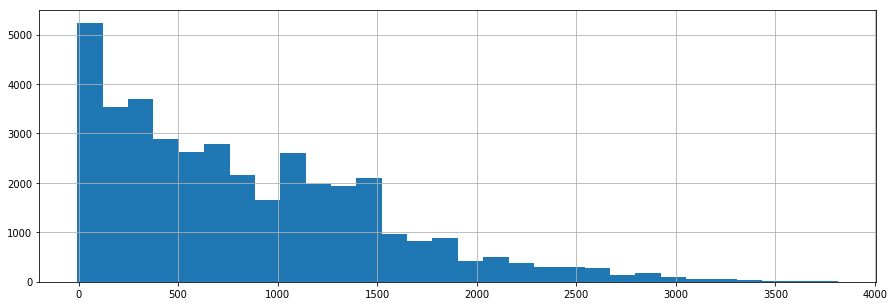

In [61]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [62]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [63]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

The same process will be followed for last_review:

In [64]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2019, 8, 6) - df.last_review).astype('timedelta64[D]')

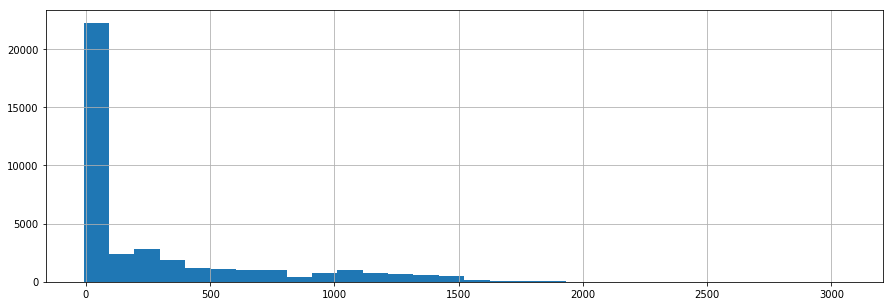

In [65]:
# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [66]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [67]:
# Dropping last_review because first_review has a greater number of recent entries. 
# First review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

**review ratings columns**

As above, listings without reviews will be kept and replaced with 'unknown'. Other ratings will be grouped into bins. The histograms below were produced in order to decide on useful bins. The majority of ratings are 9 or 10 out of 10, as also seen in the value count below. Therefore for these columns, 9/10 and 10/10 will be kept as separate groups, and 1-8/10 will be binned together (as this is, by Airbnb standards, a 'low' rating).

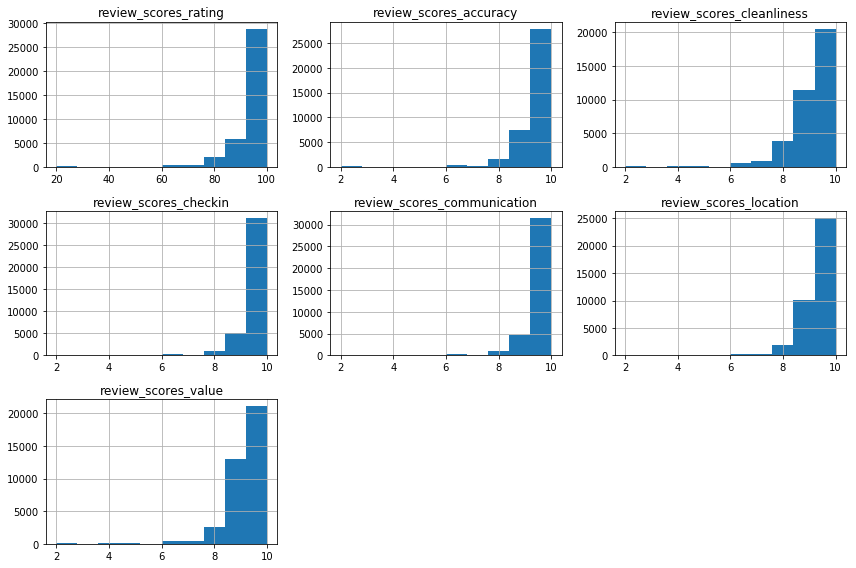

In [68]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [69]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [70]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [71]:
df['review_scores_rating'].describe()

count    37746.000000
mean        93.930430
std          8.631339
min         20.000000
25%         92.000000
50%         96.000000
75%        100.000000
max        100.000000
Name: review_scores_rating, dtype: float64

In [72]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')
print ("Done")

Done


**cancellation_policy**

Some cleaning of cancellation policy types is required, in order to categorise the four very small categories into the three larger categories (e.g. the super strict options are only available to long-term Airbnb hosts, and is invitation only).

In [73]:
df.cancellation_policy.value_counts()

strict_14_with_grace_period    21943
flexible                       15402
moderate                       11361
super_strict_60                  111
super_strict_30                   23
strict                             5
Name: cancellation_policy, dtype: int64

In [74]:
# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

**number_of_reviews_ltm and reviews_per_month**

These will be highly correlated with number_of_reviews and so will be dropped.

In [75]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

In [76]:
# List columns left in data set
print(list(df.columns.values))

['host_since', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'host_identity_verified', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'availability_90', 'number_of_reviews', 'first_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'cancellation_policy', 'host_days_active', '24-hour check-in', 'Air conditioning', 'Bed linens', 'Buzzer/wireless intercom', 'TV', 'Carbon monoxide detector', 'Pets', 'Children', 'Cooking basics', 'Washer/Dryer', 'Elevator', 'Extra pillows and blankets', 'Fire extinguisher', 'First aid kit', 'Parking', 'Hair dryer', 'Heating', 'Host greets you', 'Internet', 'Iron', 'Kitchen', 'Loc

***

# Exploratory data analysis

In [77]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 22 August 2008, and the most recent joined on 05 August 2019.


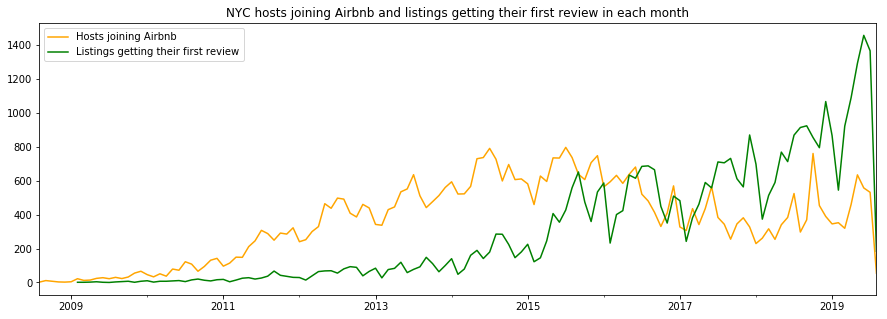

In [78]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='green')
plt.title('NYC hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-08-01', '2019-08-06') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

*Question: are the different patterns in the growth in the number of hosts and the number of listings due to hosts increasingly owning multiple properties?*

Answer: there are a number of professional Airbnb management companies which host a large number of listings under a single host profile, particularly in the 2014-2016 year range. The largest manages 1465 listings and was started in 2015, while the second largest started in 2014 and manages 1080 listings.

However, there is no consistent upwards trend in the average number of properties managed by each host.

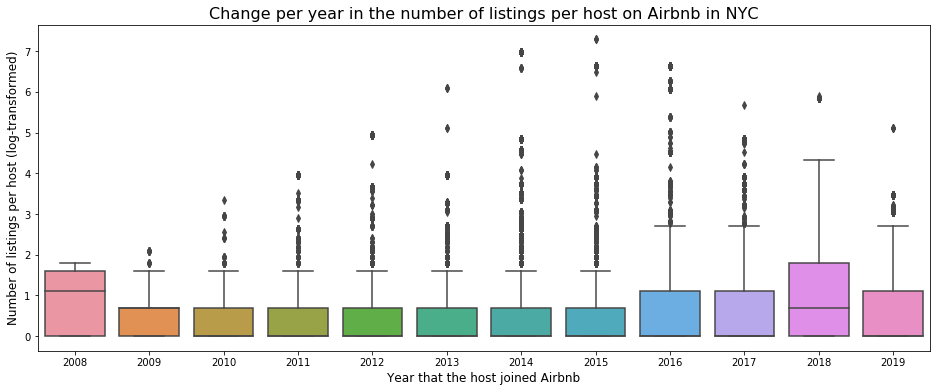

In [79]:
plt.figure(figsize=(16,6))
sns.boxplot(df.host_since.dt.year, np.log(df.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in NYC', fontsize=16)
plt.show()

In [80]:
print("Average number of listings per host per year on Airbnb in NYC:")
print(round(df.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in NYC:
host_since
2008-01-01     2.84
2009-01-01     2.02
2010-01-01     2.15
2011-01-01     3.11
2012-01-01     3.56
2013-01-01     2.69
2014-01-01    19.10
2015-01-01    14.56
2016-01-01    36.34
2017-01-01     7.37
2018-01-01    31.04
2019-01-01     3.25
Freq: AS-JAN, Name: host_listings_count, dtype: float64


In [81]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
id,,
32104047,2018-06-11,365.0
20686099,2016-06-06,435.0
11456821,2013-10-14,440.0
15230576,2016-09-16,528.0
6117496,2015-04-07,653.0
33216902,2014-12-14,725.0
13522873,2015-03-30,755.0
30387218,2016-12-16,760.0
23763165,2014-02-14,1080.0


Q: Do hosts with more properties charge more per property?

Answer: Yes, it looks like those with fewer than 20 units charge generally the same amount (between 100 and 200 USD), while hosts with 30 or more units generally charge more. Perhaps larger management companies are able to provide posher rooms, in larger, more centrally located, buildings?

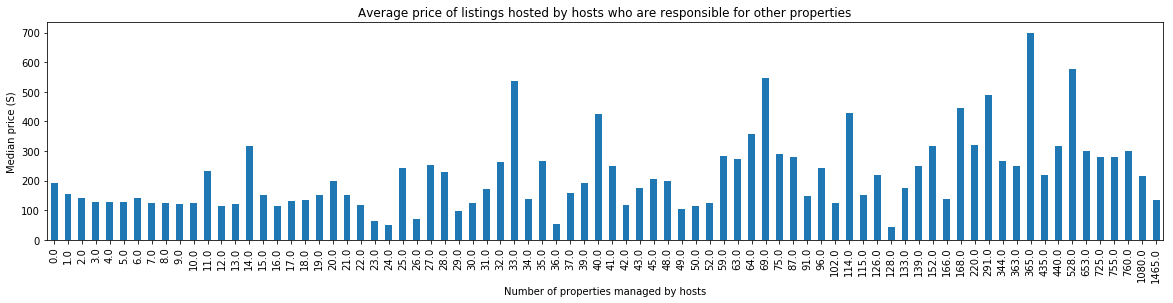

In [82]:
# Median price for different host listing counts
plt.figure()
df.groupby('host_listings_count').price.mean().plot(figsize=(20,4), kind='bar')
plt.title('Average price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price (S)');

*Question: how have prices changed over time?*

Answer: the average price per night for Airbnb listings in New York has increased slightly over the last 10 years. However, there has also been an significant increase in overall spread of the prices suggesting that as the market for Airbnbs became more saturated hosts introduced offers to satisfy consumers at every price-point.

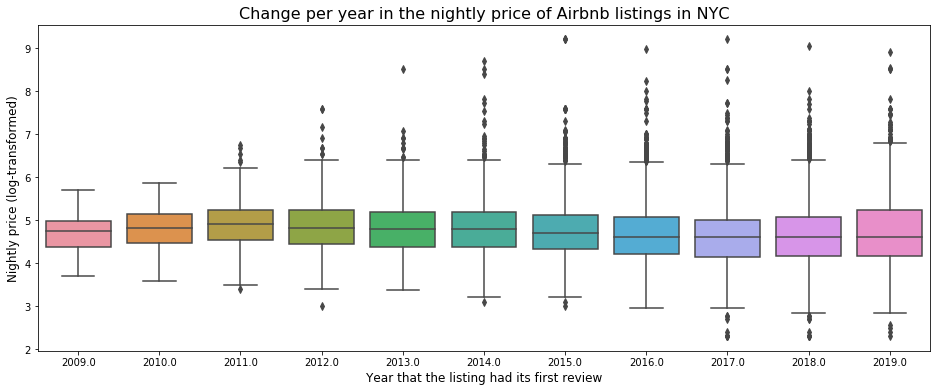

In [83]:
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in NYC', fontsize=16)
plt.show()

In [84]:
print("Mean nightly price of listings in each year on Airbnb in NYC:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in NYC:
first_review
2009-01-01    119.84
2010-01-01    137.26
2011-01-01    158.24
2012-01-01    157.97
2013-01-01    155.12
2014-01-01    156.94
2015-01-01    147.60
2016-01-01    137.16
2017-01-01    130.11
2018-01-01    133.62
2019-01-01    149.53
Name: price, dtype: float64


In [85]:
# Dropping host_since and first_review as they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

In [86]:
# List columns left in data set
print(list(df.columns.values))

['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'host_identity_verified', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'availability_90', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'cancellation_policy', 'host_days_active', '24-hour check-in', 'Air conditioning', 'Bed linens', 'Buzzer/wireless intercom', 'TV', 'Carbon monoxide detector', 'Pets', 'Children', 'Cooking basics', 'Washer/Dryer', 'Elevator', 'Extra pillows and blankets', 'Fire extinguisher', 'First aid kit', 'Parking', 'Hair dryer', 'Heating', 'Host greets you', 'Internet', 'Iron', 'Kitchen', 'Lock on bedroom door', 'Lockbox',

### Numerical features

**Price**

In [87]:
# Question: what is the overall distribution of prices?

# Answer: Nightly advertised prices range from $0 to $10,000. 
# The extreme ends of the range are due to hosts not understanding how to use Airbnb advertised prices 
# (sometimes called 'sticker' prices) correctly. The advertised prices can be set to any arbitrary amount, 
# and these are the prices that show when dates are not entered on the site.

# A model is only as good as its data, and unfortunately this model will be predicting advertised prices 
# rather than the prices actually paid. Nevertheless, some cleaning of the particularly unhelpful values will 
# be done. Unreasonably small values under $30 will be increased to $30.

# There are notable drop-offs in nightly prices at $200 (second graph, orange line), $500 (second graph- red
# line, third graph - orange line) and $1,000 (second graph, red line). Values above $1,000 will  be reduced to $1,000.

In [88]:
print(f"Nightly advertised prices range from ${min(df.price)} to ${max(df.price)}.")

Nightly advertised prices range from $0 to $10000.


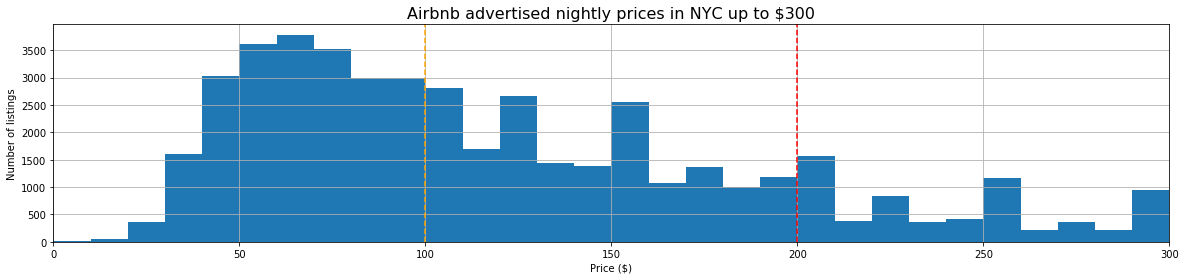

In [89]:
# Distribution of prices from $0 to $300
plt.figure(figsize=(20,4))
df.price.hist(bins=30, range=(0,300))
plt.margins(x=0)
plt.axvline(100, color='orange', linestyle='--')
plt.axvline(200, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in NYC up to $300", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

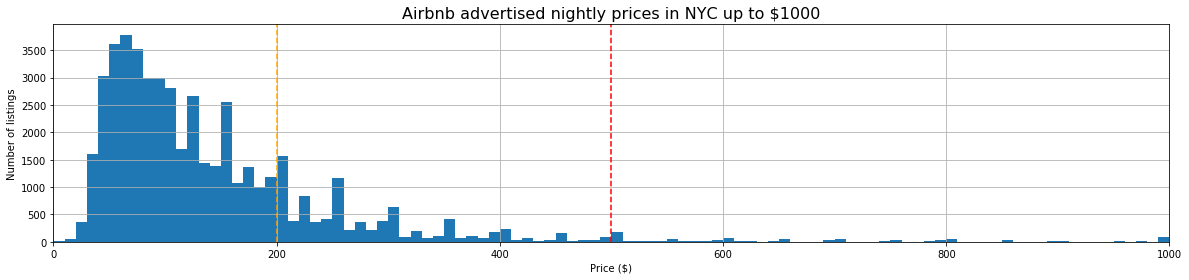

In [90]:
# Distribution of prices from $0 to $1000
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.axvline(500, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in NYC up to $1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

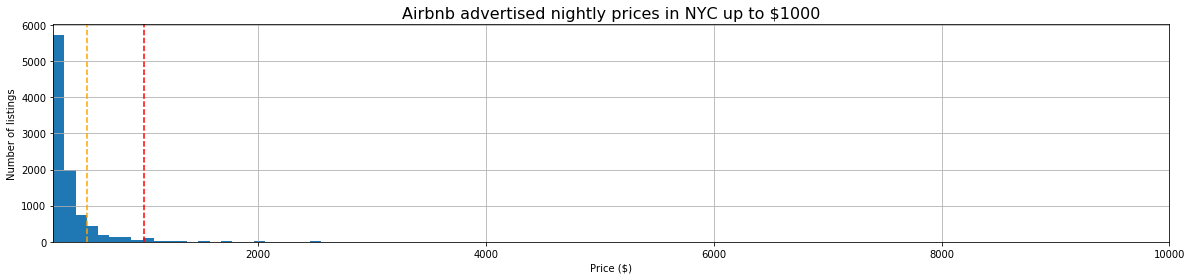

In [91]:
# Distribution of prices from $200 upwards
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(200, max(df.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in NYC up to $1000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [92]:
# Replacing values under $30 with $30
df.loc[df.price <= 30, 'price'] = 30

# Replacing values over $1000 with $1000
df.loc[df.price >= 1000, 'price'] = 1000

**Host listings count**

*Question: how many listings do hosts have on average? How many multi-listing hosts are there?*

Answer: the median number of listings that the host of each listing has is 1, i.e. the majority of hosts only manage one listing. The mean is much higher (15 in total) due to some hosts managing large numbers of listings (as discussed above where management companies offer hundreds of rooms). More than half of listings are from hosts with one listing, and about two-fifths are from multi-listing hosts. 

Two difficulties in discerning how many listings hosts have on average are:
- this number is only known on the level of the listing, so hosts with more listings are represented more frequently (e.g a host with 10 listings may be represented up to 10 times in the dataset)
- a host's other listings may not be in NYC, so some multi-listing hosts may appear multiple times in the dataset, and others may appear only once
- users may create multiple profiles for the same space (roommates may list the apartment as a whole, partners may have a joint account or seperate accounts, multi-listing hosts may have multiple accounts to increase volume, etc).

In [93]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 15
58% of listings are from hosts with one listing.


**Number of people accommodated, bathrooms, bedrooms and beds**

*Question: what are the average number of people accommodated, bathrooms, bedrooms and beds in Airbnb listings in NYC, and how do prices differ?*

Answer: the most common property setup sleeps two people in one bed in one bedroom, with one bathroom. Unsurprisingly, properties that accommodate more people achieve noticeably higher nightly rates, with diminishing returns coming after about 10 people.

Some properties have very high looking values for some features (e.g. one property claims to have 17 bathrooms), but these will be left for now in the interests of time (as double-checking them would be time-consuming).

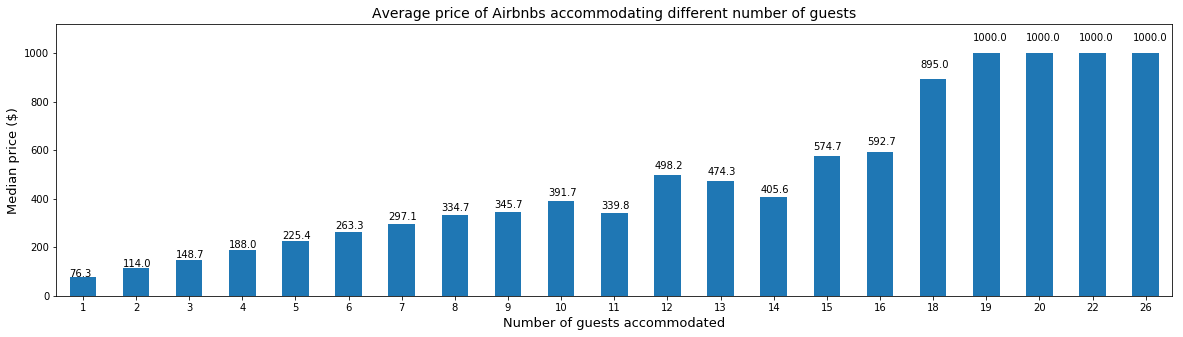

In [94]:
plt.figure(figsize=(20,5))
DUN1 = df.groupby('accommodates').price.mean().round(1).plot(kind='bar')
for p in DUN1.patches:
    DUN1.annotate(str(p.get_height()), (p.get_x(), p.get_height() * 1.05))
plt.margins(y=.12)
plt.title('Average price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=-0.5)
plt.show()

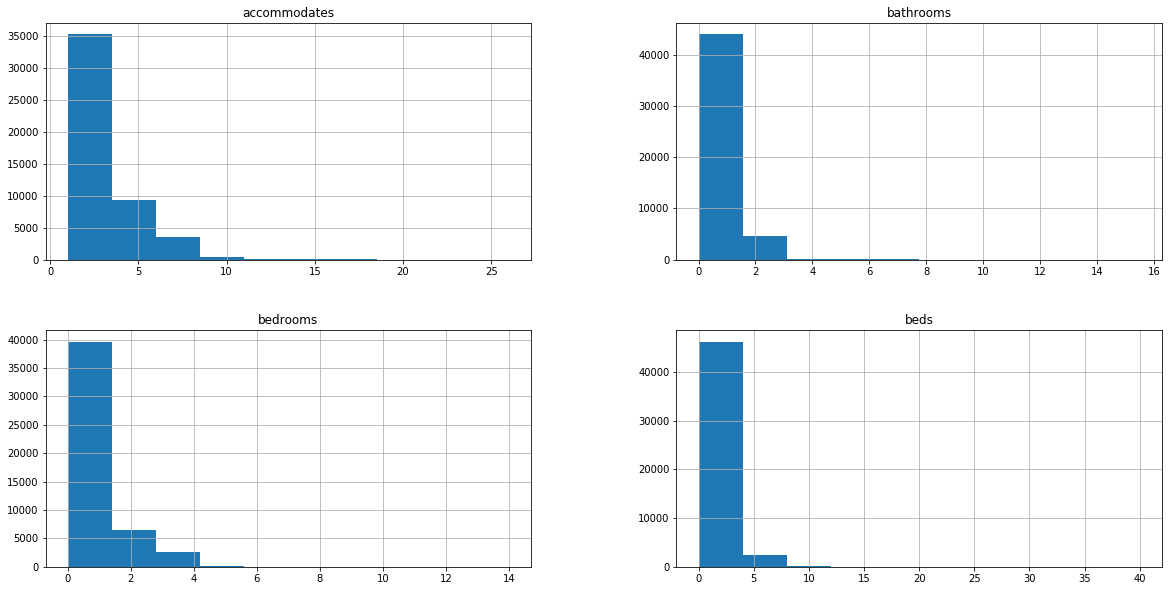

In [95]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(20,10));

### Categorical features

Categorical features will be explored and plotted, to gain insights and to determine whether or not they should be included in the final model.

**Neighbourhood**

*Question: which areas have the most Airbnb properties, and which are the most expensive?* 

Answer: Several parts of Brooklyn have the highest number of AirBnB listings followed by the areas surroungin Central Park (e.g. Upper West Side, Upper, East Side, Hell's Kitchen) likely due to the relatively high amount of housing in these areas that would likely spur more overall volume of Airbnbs.

Highest priced AirBnB areas, however, are in the areas parts of New York the least number of total AirBnB rentals (e.g. Staten Island) suggesting that the standout prices are due to other areas of New York falling victim to the law of averages. The exceptino to this is Manhattam that shows strong AirBnB population at relatively higher rates than the surrounding boroughs

In [96]:
print(df.columns.values)

['host_response_time' 'host_response_rate' 'host_is_superhost'
 'host_listings_count' 'host_identity_verified' 'neighbourhood_cleansed'
 'neighbourhood_group_cleansed' 'zipcode' 'property_type' 'room_type'
 'accommodates' 'bathrooms' 'bedrooms' 'beds' 'price' 'security_deposit'
 'cleaning_fee' 'guests_included' 'extra_people' 'availability_90'
 'number_of_reviews' 'review_scores_rating' 'review_scores_accuracy'
 'review_scores_cleanliness' 'review_scores_checkin'
 'review_scores_communication' 'review_scores_location'
 'review_scores_value' 'instant_bookable' 'cancellation_policy'
 'host_days_active' '24-hour check-in' 'Air conditioning' 'Bed linens'
 'Buzzer/wireless intercom' 'TV' 'Carbon monoxide detector' 'Pets'
 'Children' 'Cooking basics' 'Washer/Dryer' 'Elevator'
 'Extra pillows and blankets' 'Fire extinguisher' 'First aid kit'
 'Parking' 'Hair dryer' 'Heating' 'Host greets you' 'Internet' 'Iron'
 'Kitchen' 'Lock on bedroom door' 'Lockbox' 'Long term stays allowed'
 'Luggage dro

In [97]:
# Renaming the neighbourhood column
df.rename(columns={'neighbourhood_cleansed': 'neighbourhood', 'neighbourhood_group_cleansed': 'borough'}, inplace=True)

In [98]:
# Importing the New York borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('neighbourhoods.geojson')
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Bayswater,Queens,"(POLYGON ((-73.76670799999999 40.614911, -73.7..."
1,Allerton,Bronx,"(POLYGON ((-73.848597 40.87167, -73.845823 40...."
2,City Island,Bronx,"(POLYGON ((-73.782822 40.843919, -73.782572 40..."
3,Ditmars Steinway,Queens,"(POLYGON ((-73.90160299999999 40.76777, -73.90..."
4,Ozone Park,Queens,"(POLYGON ((-73.83754399999999 40.691364, -73.8..."


In [99]:
# Creating a dataframe of listing counts and median price by neighbourhood
neighbourhood_df = pd.DataFrame(df.groupby('neighbourhood').size())
neighbourhood_df.rename(columns={0: 'number_of_listings'}, inplace=True)
neighbourhood_df['median_price'] = df.groupby('neighbourhood').price.median().values
# borough_df.head()

# # Joining the dataframes
neighbourhood_map_df = map_df.set_index('neighbourhood').join(neighbourhood_df)
neighbourhood_map_df['number_of_listings'].fillna(0)
neighbourhood_map_df['median_price'].fillna(0)
neighbourhood_map_df.head()

,neighbourhood_group,geometry,number_of_listings,median_price
neighbourhood,,,,
Allerton,Bronx,"(POLYGON ((-73.848597 40.87167, -73.845823 40....",41.0,70.0
Arden Heights,Staten Island,"(POLYGON ((-74.169827 40.561078, -74.169822999...",4.0,72.5
Arrochar,Staten Island,"(POLYGON ((-74.06077999999999 40.593188, -74.0...",23.0,69.0
Arverne,Queens,"(POLYGON ((-73.789535 40.599972, -73.789541 40...",86.0,125.0
Astoria,Queens,"(POLYGON ((-73.90160299999999 40.76777, -73.90...",926.0,80.0


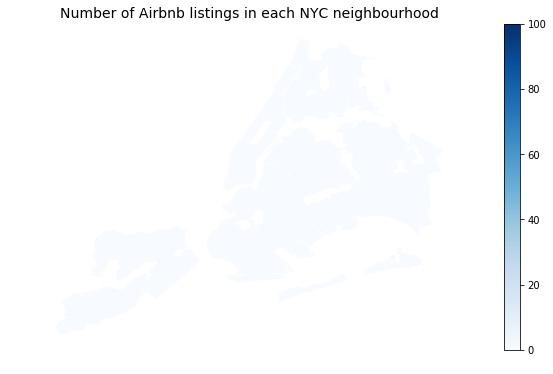

In [100]:
# Plotting the number of listings in each neighbourhood
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each NYC neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=100))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

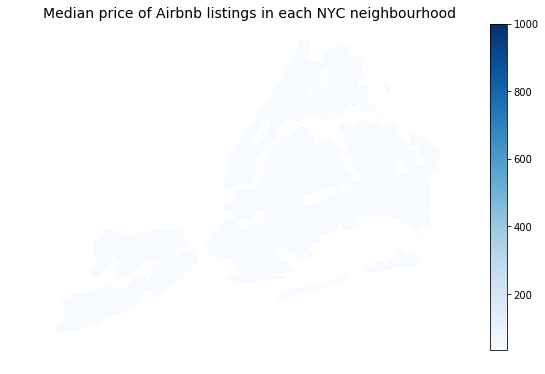

In [101]:
# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(10, 6))
neighbourhood_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each NYC neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(neighbourhood_map_df.median_price), vmax=max(neighbourhood_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

**Property and room types**

*Question: what are the most common property and room types?*

Answer: Of the almost 50,000 AirBnB properties available in NYC, about 87% of properties were some type of apartment. The remainder were houses or more uncommon property types (e.g. 'boat' or 'tent').

About 52% of listings were entire homes or apartments (i.e. you are renting the entire space on your own). Most of the remainder were private rooms (i.e. you are renting a bedroom and possibly also a bathroom, but there will be other people in the property). Surprisingly, 2.4% were shared rooms (i.e. you are sharing a room with either the property owner or other guests).

In [102]:
df.property_type.count()

48846

In [103]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

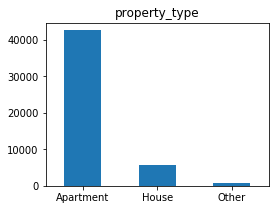

Apartment    0.871433
House        0.114728
Other        0.013839
Name: property_type, dtype: float64


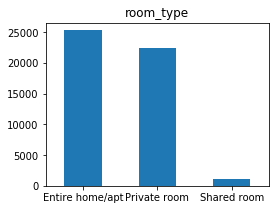

Entire home/apt    0.517709
Private room       0.458318
Shared room        0.023973
Name: room_type, dtype: float64


In [104]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(df[col].value_counts(normalize=True))

**Reviews**

*Question: what is the distribution of reviews like?*

Answer: for  every review category, the majority of listings that have had a review have received a 10/10 rating for that category (or 95-100/100 overall) - clearly people love their Airbnbs. Ratings or 8 or below are rare. Guests seem to be most positive about communication, check-ins and accuracy. As noted previously, about a quarter of listings have not yet been reviewed.

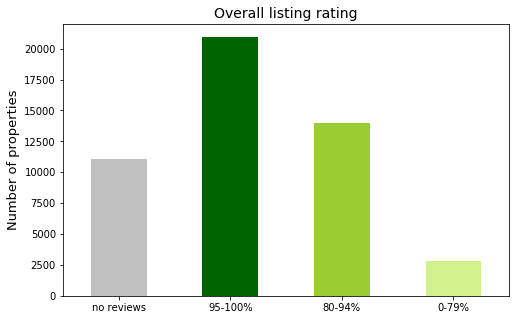

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Overall listing rating', fontsize=14)
df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['silver', 'darkgreen', 'yellowgreen', '#d1f28a' ], ax=ax)
ax.set_xticklabels(labels=['no reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

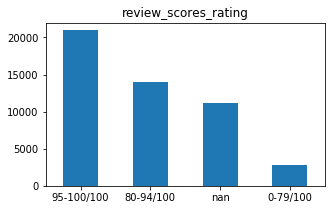

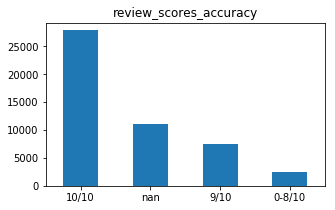

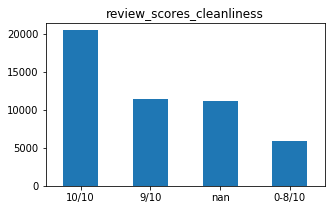

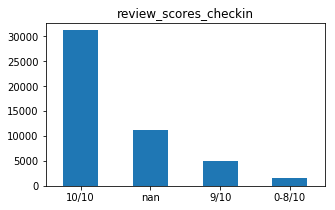

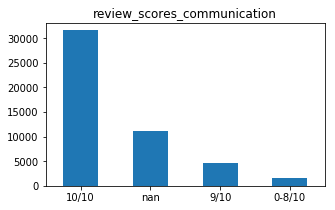

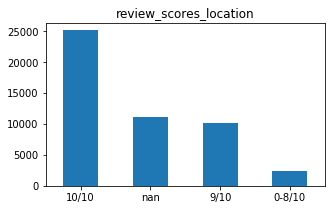

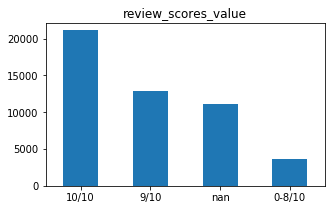

In [106]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

**First and last reviews**

*Question: how long have listings been on the site, and how many listings have been reviewed recently?*

Answer: the most common time period in which currently live Airbnb listings had their first review is 2-3 years ago. This means that a lot of listings on the site have been active for at least a couple of years. On the other hand, only about 13% of all listed properties were on the site for more than 4 years. 

The most common category for the time since a listing received its last review is 2-8 weeks ago. This means that a lot of listings have been reviewed relatively recently. However, there are still over 10,000 listings which have not had a review for more than a year, and about 10,000 other listings which have never been reviewed. The majority of these are probably what are sometimes referred to 'inactive' listings, because although they are technically live on the site, they either do not have their calendars open, are not available to book, are new, or are missing information to make them available.

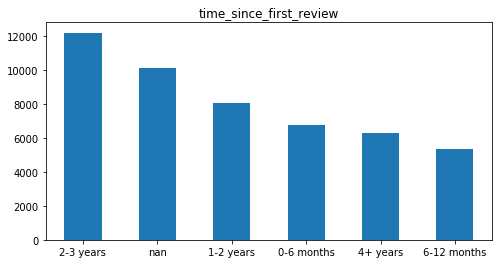

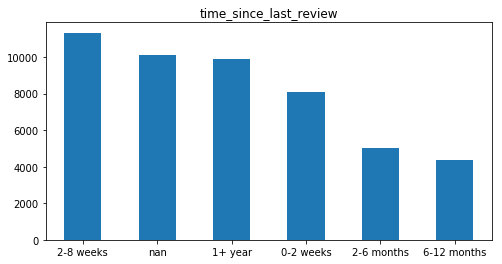

In [107]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

### Boolean (true or false) features

Many features (e.g. for amenities) can be true or false. This section compares the proportions of these features that are true or false (to explore the data and also to ascertain whether the feature is worth retaining), and the median price of each category (to explore the relationship between the category and price).

In [108]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['No', 'Yes'], rotation=0)
    ax1.set_title('Is this true for the listing')
    ax1.set_xlabel('')
    
    df.groupby(col).price.mean().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['False', 'True'], rotation=0)
    ax2.set_title('Average price ($) if:')
    ax2.set_xlabel('')
    
    plt.show()

**Superhosts**

*Question: what proportion of Airbnb hosts are superhosts, and is it worth being one? (a question often asked by hosts)*

Answer: about 15% of hosts are superhosts. However, it does not seem to improve the median price per night of their Airbnb listings, so it is arguable whether or not it is worth it (from a purely financial perspective).

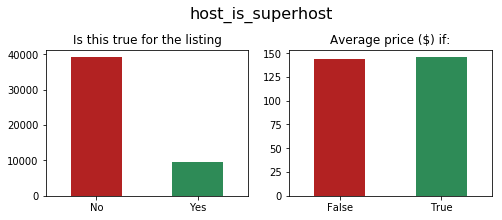

0.0    0.803935
1.0    0.196065
Name: host_is_superhost, dtype: float64


In [109]:
binary_count_and_price_plot('host_is_superhost')
print(df.host_is_superhost.value_counts(normalize=True))

**Host verification**

*Question: how many hosts are verified, and is it worth it? (a question often asked by hosts)*

Answer: About 48% of hosts are verified (e.g. by providing ID and verifying your phone number and email address), perhaps it is something that hosts often think they are expected to do. Interestingly, however, despite the fact that one might expect the additional trust commanded by verified hosts to result in higher nightly prices, there is no discernable difference between the median nightly prices of listings with verified and unverified hosts. This column will be left in the dataframe, however, in case it has any useful interactions with other features.

In [110]:
df.host_identity_verified.value_counts(normalize=True)

0.0    0.518036
1.0    0.481964
Name: host_identity_verified, dtype: float64

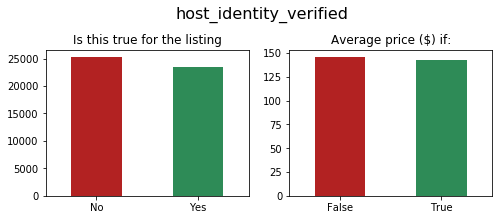

In [111]:
binary_count_and_price_plot('host_identity_verified')

**Instant booking**

*Question: how many properties are instant bookable (i.e. able to be booked without messaging the host first), and is it worth it?*

Answer: only about 35% of properties are instant bookable. However, the added convenience does not seem to have any effect on the average price per night.

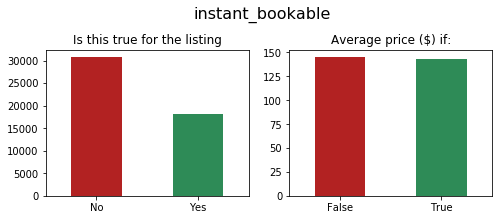

0    0.630574
1    0.369426
Name: instant_bookable, dtype: float64


In [112]:
binary_count_and_price_plot('instant_bookable')
print(df.instant_bookable.value_counts(normalize=True))

**Amenities**

*Question: which amenities are common, and which increase the price of an Airbnb listing?*

Answer: amenities can be split into four main groups:

Uncommon, but properties with it have a higher average price:
- Allowing pets
- Being baby/child/family friendly
- Having cooking basics, like a dishwasher, coffee-maker, etc.
- Having a washer or dryer or both
- Having an elevator
- Providing extra pillows and blankets
- Offering privacy in the form of self- check-in, a private enterance, a private living room, or a private bathroom

Most properties have it, and properties with it have a higher average price:
- Installing a shower, providing shampoo
- Providing an iron, a hair dryer
- Making sure there is heat in the space
- Mentioning a TV or cable
- Having a carbon monoxide detector installed

Most properties have it, and there is no major difference in price between properties with and without it:
- Providing internet or wifi
- Providing a kitchen or cooking space

Uncommon, and properties with it have a lower average price:
- Mentioning parking!
- Mentioning that the Host will greet the customer!
- Having a lock on the bedroom door!

The takeaway from this is that there are some things that Airbnb hosts can do to try and improve their listing's price, although there is often not a simple causative relationship (e.g. having a parking space might improve your price, but listings with parking spaces are cheaper on average because they are less likely to be in central NYC, and location is a more important factor than parking space):
- **Make sure you have the necessities that your competitors also have**, e.g. internet and a space to cook/microwave
- If you can, **include some extras to make your property stand out and achieve a higher price**. For example, you could buy a coffee machine, allow self check-in, provide extra pillows or blankets, and make your property child-friendly.
- **Avoid greeting the customer** as many New Yorkers dislike that and it might harm the financial performance of your property.

In [113]:
for col in df.iloc[:,31:-2].columns:
    print(col)

24-hour check-in
Air conditioning
Bed linens
Buzzer/wireless intercom
TV
Carbon monoxide detector
Pets
Children
Cooking basics
Washer/Dryer
Elevator
Extra pillows and blankets
Fire extinguisher
First aid kit
Parking
Hair dryer
Heating
Host greets you
Internet
Iron
Kitchen
Lock on bedroom door
Lockbox
Long term stays allowed
Luggage dropoff allowed
Privacy
Shower


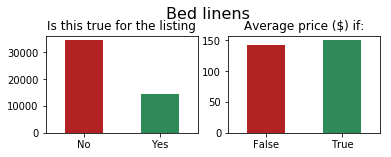

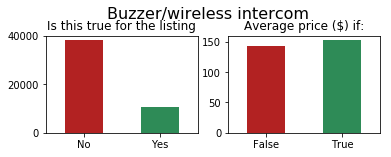

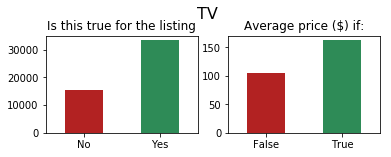

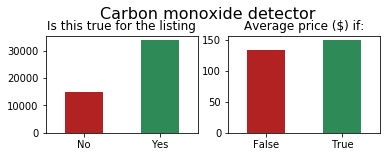

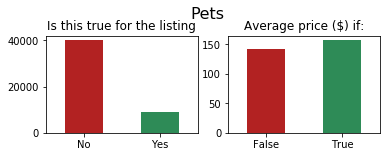

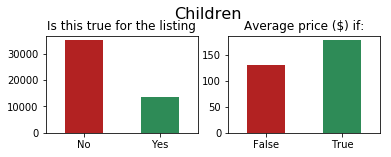

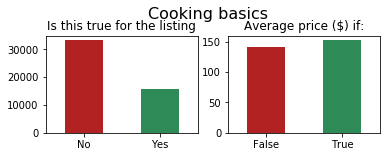

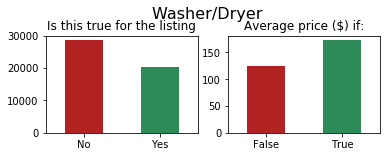

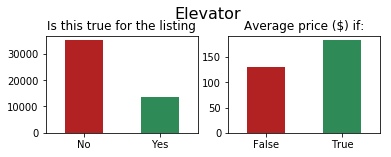

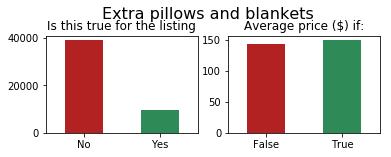

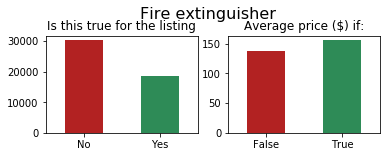

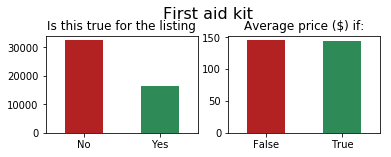

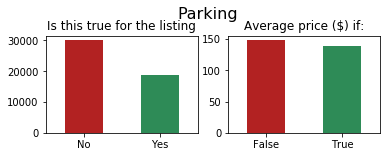

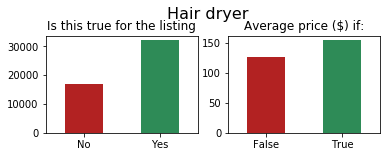

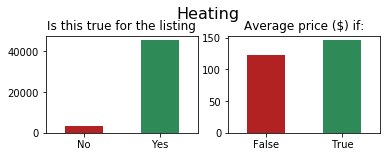

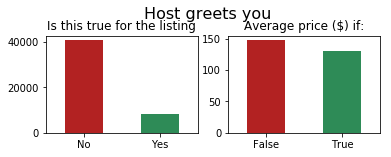

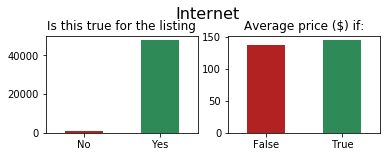

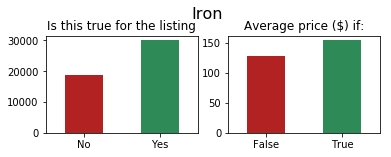

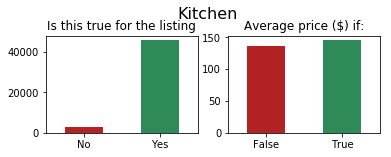

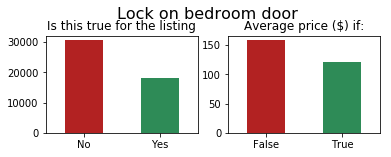

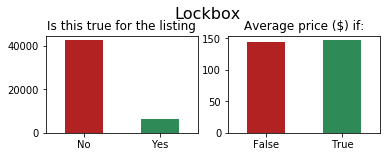

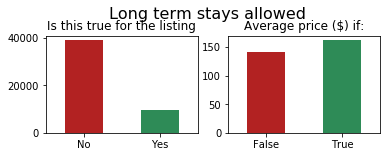

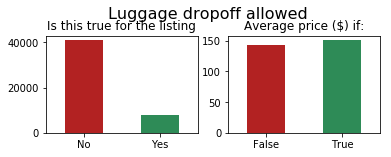

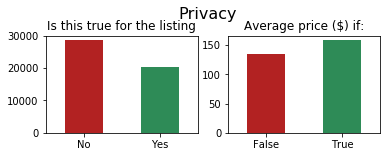

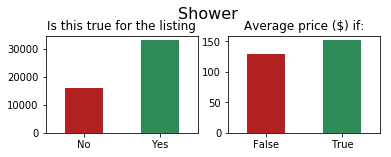

In [114]:
for col in df.iloc[:,33:-2].columns:
    binary_count_and_price_plot(col, figsize=(6,2))

# Preparing the data for modeling

**Dropping columns and assessing multi-collinearity**

Collinearity is a condition in which some of the independent variables are highly correlated. Why is this a problem? Collinearity tends to inflate the variance of at least one estimated regression coefficient. The remedy is to identify and drop one of the variables which are highly correlated. Categorical variables will now be one-hot encoded:

In [115]:
# Drop zip code and borough
df.drop('zipcode', axis=1, inplace=True)
df.drop('borough', axis=1, inplace=True)
# df.columns.values

In [116]:
transformed_df = pd.get_dummies(df)

The dataset can now be assessed for multi-collinearity.

In [117]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

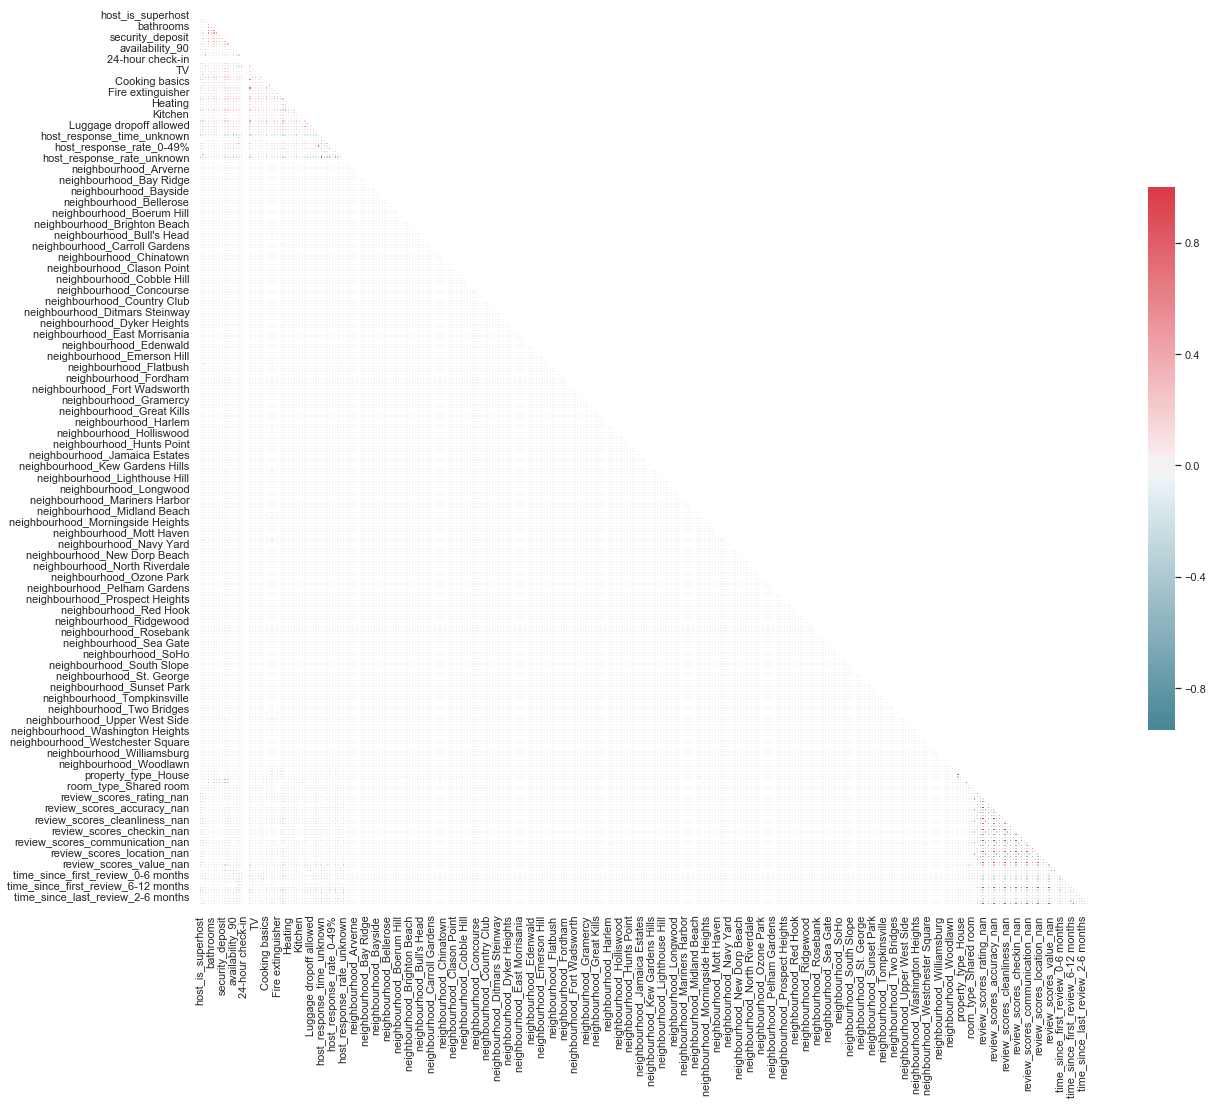

In [118]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

It doesn't look like there are any significant collinear relationships with neighbourhoods, so these will temporarily be dropped to produce a clearer heatmap for the remaining features:

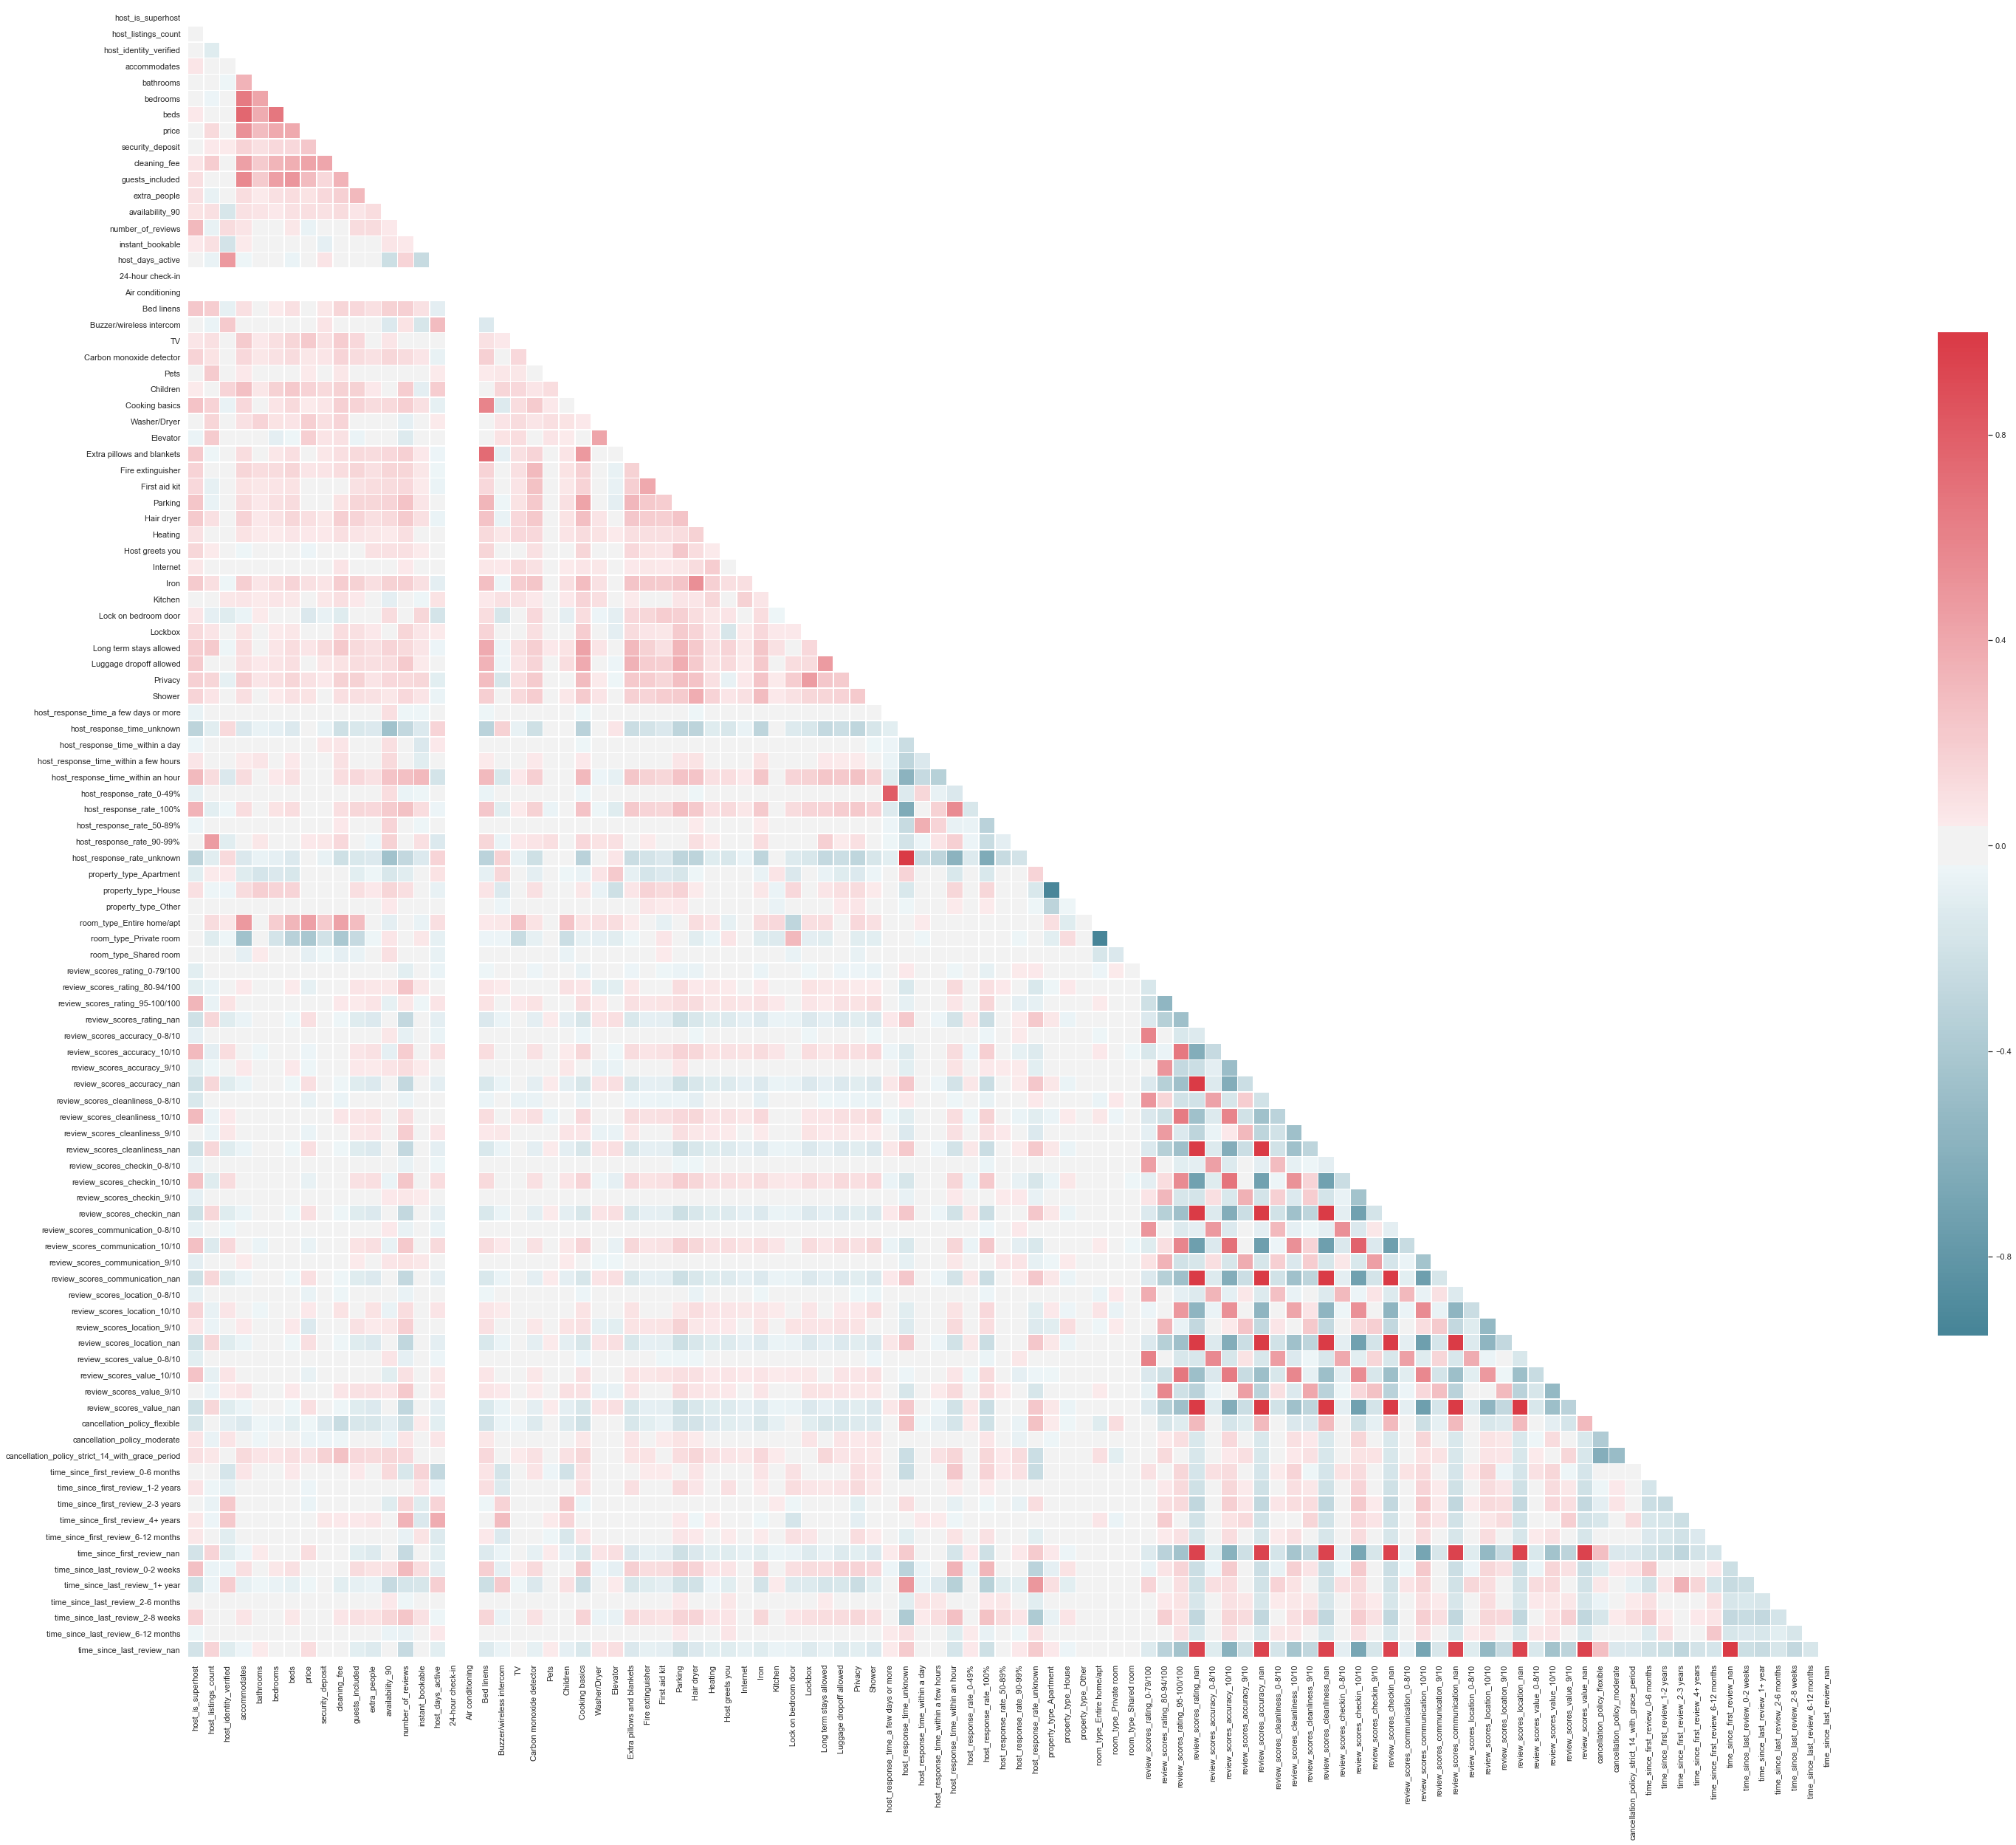

In [119]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1), figsize=(50,50))

Areas of multi-collinearity:

- Beds, bedrooms, guests included and the number of people that a property accommodates are highly correlated. The number of people accommodated has traditionally been a more high priority search parameter on Airbnb, as it is more relevant for private and shared rooms than the number of bedrooms (and is still the second highest priority parameter when searching on the site, after dates (when read from left to right on the search page)).
- Unsurprisingly, there are perfect correlations between NaN reviews (i.e. listings that are not reviewed yet) for different review categories, and first and last review times. NaN categories can therefore be dropped.
- The same is true of unknown host response rates and times. One of these (rate) will be dropped.
- There is a correlation between a 0-49% response rate, and an average response time of a few days or more. One of these (rate) will be dropped.
- There are strong negative correlations between houses and apartments, and between private rooms and entire homes (as these were the main two categories of their features before they were one-hot encoded). Although these are important categories, one of each will be dropped in order to reduce multi-collinearity (apartments and private rooms, as these are the second most common categories).

In [120]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

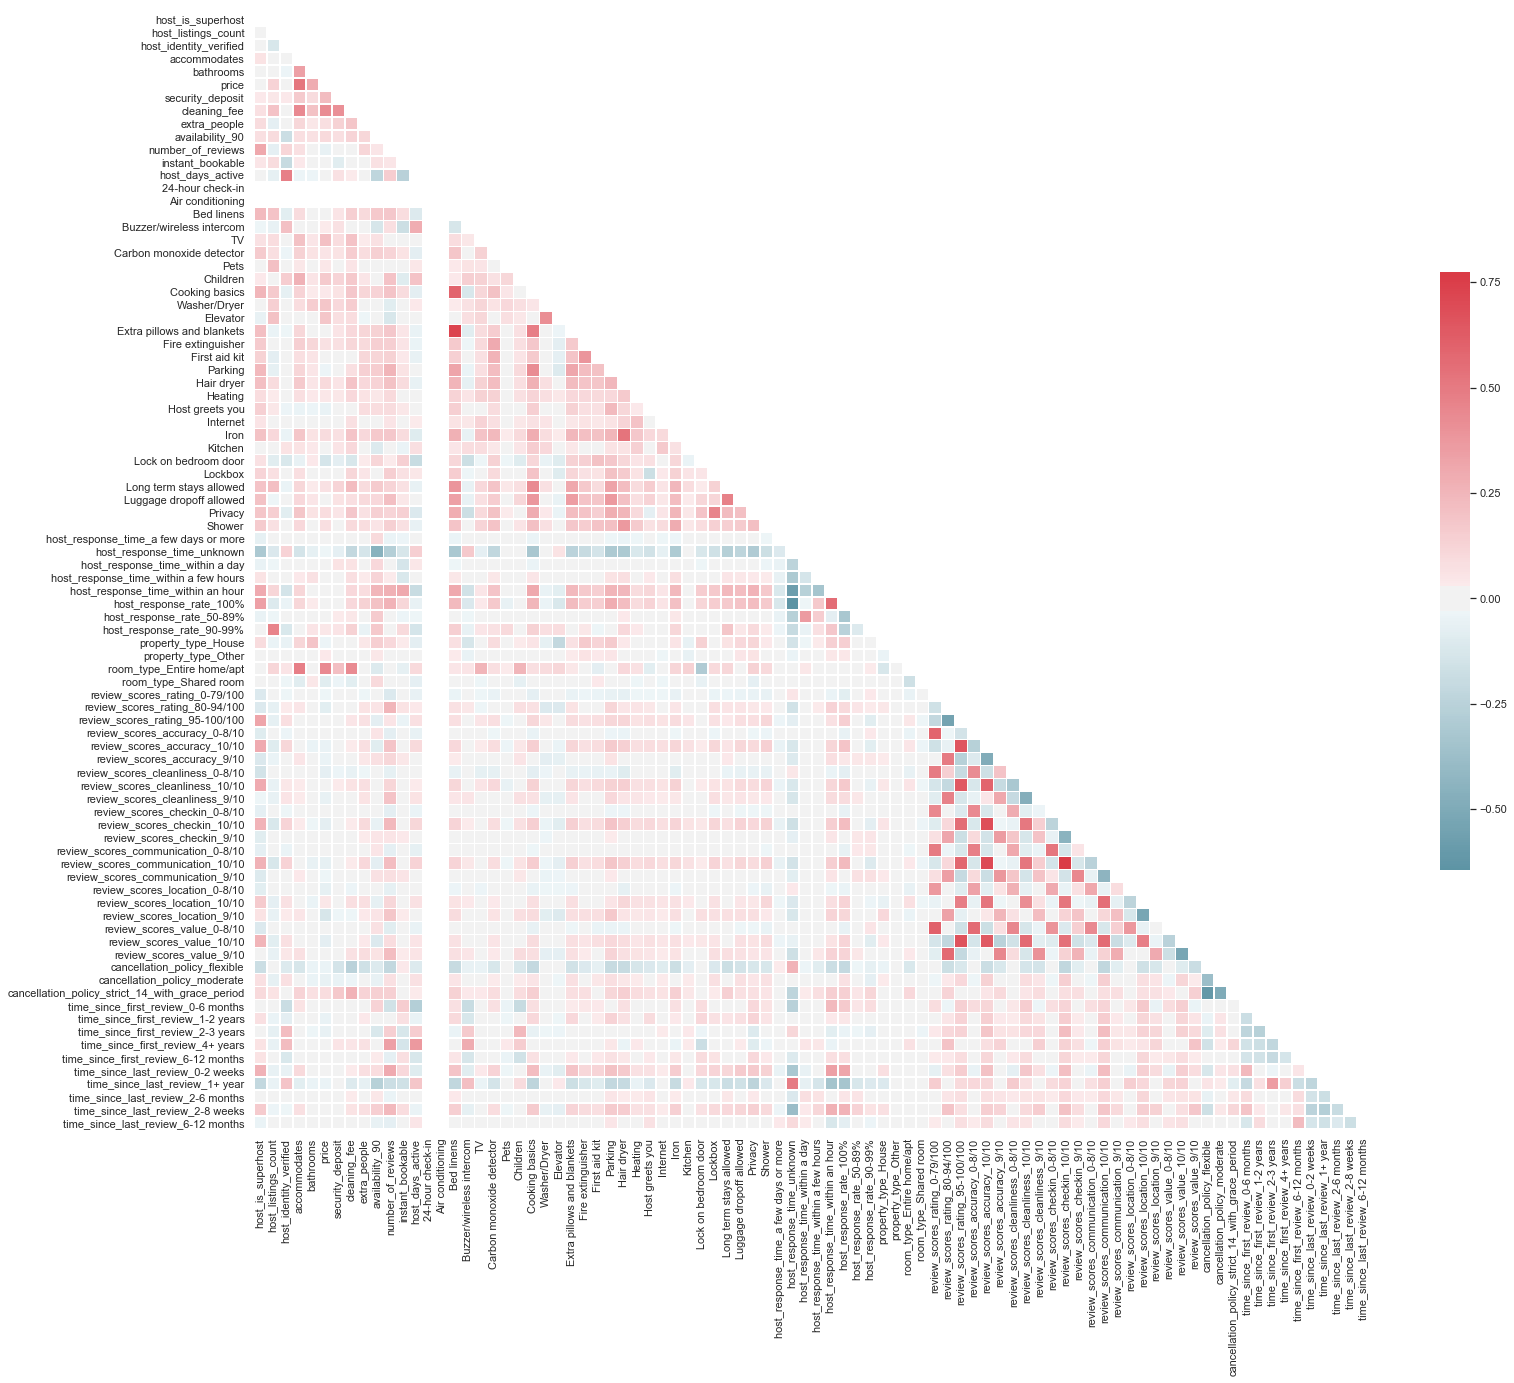

In [121]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

There are still some fairly strong correlations between highly rated properties of different reviews categories - i.e. if a property gets a 10/10 for one category, it is likely to get a 10/10 for other categories. However, these will be left in for now and can be experimented with later to see if removing them improves the model.

**Standardising and normalising**

Other than availability_90 and host_days_active, the remaining numerical features are all postively skewed and could benefit from log transformation.

In [122]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'number_of_reviews', 'price', 'security_deposit']

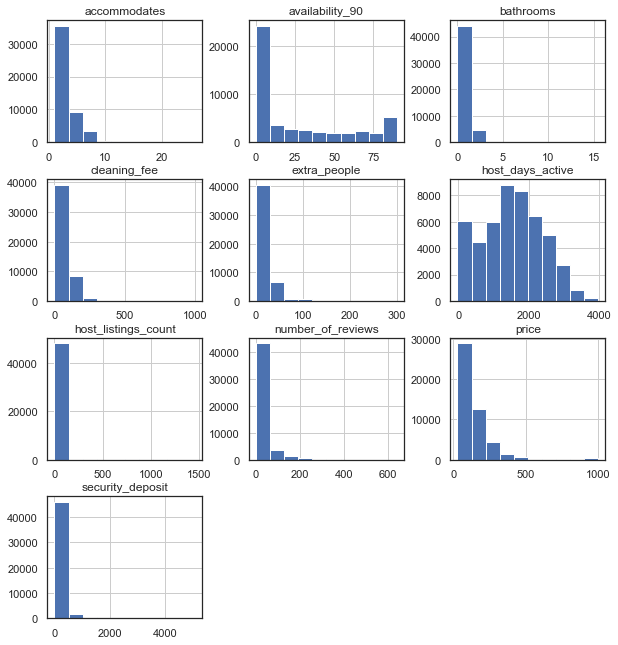

In [123]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [124]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

This appears to have helped some of the distributions, although some (e.g. cleaning fee, extra people fee and security fee) contain a large number of 0s, which means these features are not normally distributed. Most importantly, however, the target variable price now appears much more normally distributed.

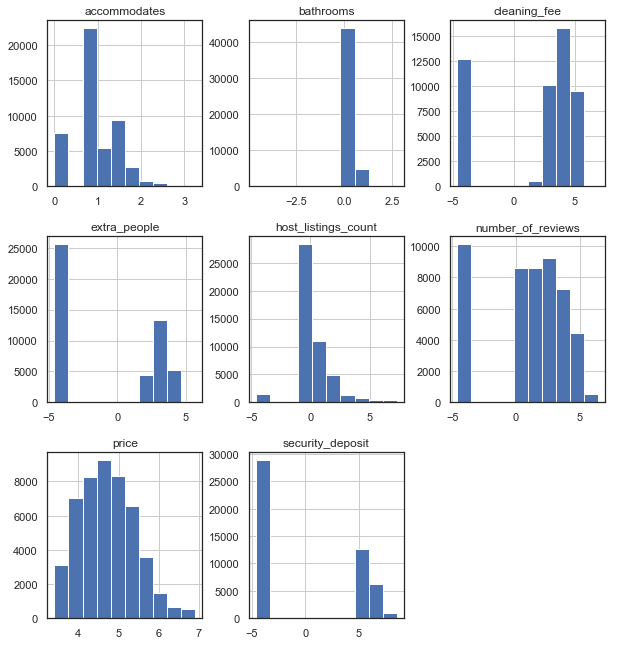

In [125]:
transformed_df[numerical_columns].hist(figsize=(10,11));

Finally, the predictive features X and the target feature y can be separated, and X will be scaled. StandardScaler from sklearn will be used, but the type of scaling used could be experimented with later to see if alternative versions yield better results.

In [126]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

C:\Users\Work\Anaconda3\envs\PythonData\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Work\Anaconda3\envs\PythonData\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


***

# Building a ML model

In this section several machine learning and deep learning models will be built in order to predict an Airbnb listing's price.

The evaluation metrics used will be mean squared error (for loss) and r squared (for accuracy).

In [127]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Model 1: XGBoost

Before building a neural network, a vanilla XGBoost model will be used to predict price, in order to provide a baseline level of accuracy and a measure of feature importance. This most likely provides the best achievable accuracy using machine learning models (other than possible small accuracy increases from hyper-parameter tuning) due to XGBoost's superior performance.

In [128]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

[11:41:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 1.4 minutes

Training MSE: 0.1473
Validation MSE: 0.1523

Training r2: 0.6791
Validation r2: 0.6665


In [129]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg

,weight
room_type_Entire home/apt,0.465250
bathrooms,0.050106
Elevator,0.030715
TV,0.026559
neighbourhood_Midtown,0.024292
review_scores_location_9/10,0.023467
cleaning_fee,0.020266
accommodates,0.020007
neighbourhood_Bushwick,0.014592
neighbourhood_Bedford-Stuyvesant,0.014178


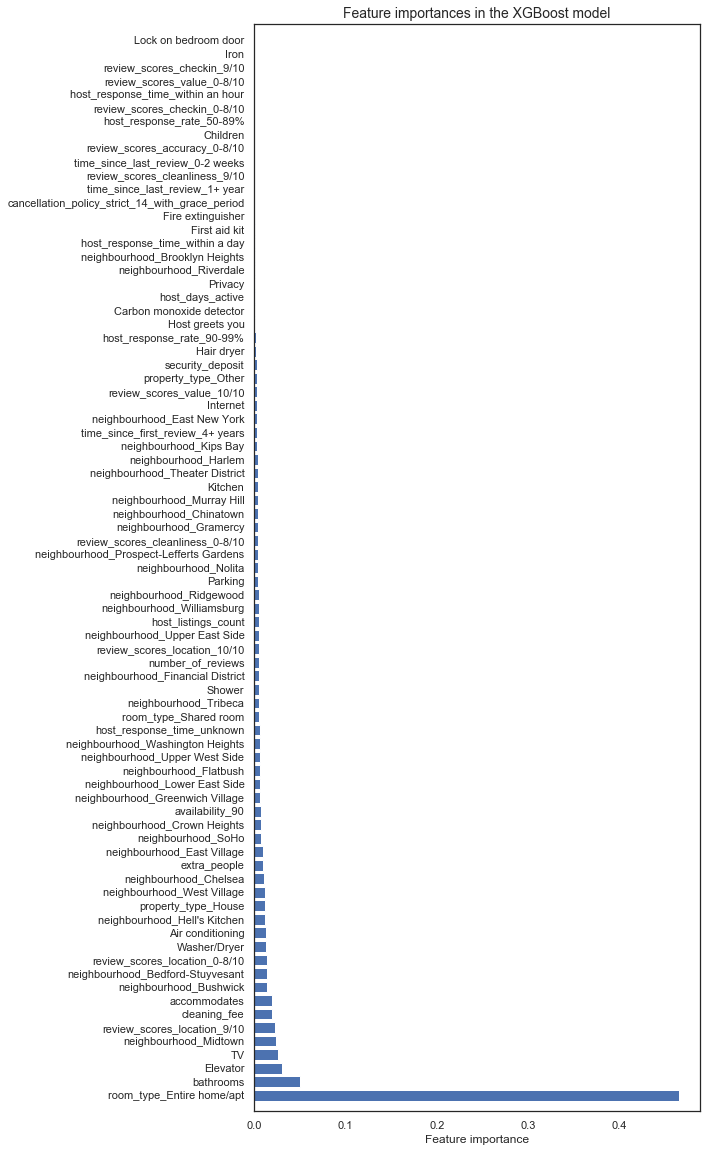

In [130]:
# we hide weights of 0 for a much cleaner chart :D 
cleaned_df = ft_weights_xgb_reg.loc[ft_weights_xgb_reg['weight'] != 0.0]


# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(cleaned_df.index, cleaned_df.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

About a third of features have a feature importance of 0 in this XGBoost regression model, and could potentially be removed (although they will not be for the deep learning modeling part of this project, as they may have interactions with other features).

**The top 10 most important features are:**
- room_type_Entire home/apt
- bathrooms
- Elevator
- TV
- neighbourhood_Midtown
- review_scores_location_9/10
- cleaning_fee
- accommodates
- neighbourhood_Bushwick
- neighbourhood_Bedford-Stuyvesant

It is not surprising that the most important feature is if the space is the entire home or apartment or shared, as that's one of the main things you would use to search for properties with in the first place. It is also not surprising that features related to location and reviews are in the top ten, as these most often drive up the price.

***

# Conclusions and recommendations

This is one of those situations where deep learning simply isn't necessary for prediction, and a machine learning model performs just as well.
However, even in the best performing model, the model was only able to explain 67% of the variation in price. The remaining 33% is probably made up of features that were not present in the data. It is likely that a significant proportion of this unexplained variance is due to variations in the listing photos. The photos of properties on Airbnb are very important in encouraging guests to book, and so can also be expected to have a significant impact on price - better photos (primarily better quality properties and furnishings, but also better quality photography) equal higher prices.

**Potential directions for future work**
- Find a way to incorporate image quality into the model, e.g. by using the output of a convolutional neural network to assess image quality as an input into the pricing model 
- Use better quality/more accurate data which includes the actual average prices paid per night
- Include a wider geographic area, e.g. the rest of the US or other major cities around the world
- Augment the model with natural language processing (NLP) of listing descriptions and/or reviews, e.g. for sentiment analysis or looking for keywords
- Tailor the model more specifically to new listings in order to help hosts set prices for new properties, by removing features that would not be known at the time - e.g. other fees, availability and reviews